## AMBER Learning CBF Script

In [65]:
import sys
sys.executable

'/usr/bin/python3'

In [66]:
### VERSION REQUIREMENTS: 
# Please use Tensorflow 1.8 and Keras 2.2.0, otherwise it could cause a problem

# Imports

# Data Processing
import numpy as np
from numpy import array, concatenate, dot, genfromtxt, savetxt, shape
from numpy.random import permutation
import pickle 


# Learning
#from tensorflow.logging import ERROR, set_verbosity
#set_verbosity(ERROR)
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import Model, Sequential
import keras.backend as K
from keras.layers import Add, Dense, Dot, Input, Reshape
from tensorflow import linalg
# Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cla, clf, figure, grid, legend, plot, savefig, show, subplot, title, xlabel, ylabel

In [73]:
class learned_model_1_layer: 
    
    def __init__(self, filename, which_barrier): 
        self.filename = filename[:-4]
        print(filename)
        
        # Model parameters
        self.d_drift_in =20 # dimension of drift model input
        self.d_act_in = 20 # dimension of actuation model input
        self.d_hidden= 50 # number of nodes in hidden layer
        self.d_out = 1 # dimension of combined model output
        self.m = 4 # dimension of control inputs
        
        # Training Parameters
        self.optimizer = 'adam'
        self.loss = 'mean_absolute_error'
        self.regularization = "off"
        self.regularization_weight = 0.5
        self.batch_size = 10
        self.num_epochs = 10
        self.validation_split = 0.1
        
        
        # Barrier Function Parameters
        
        if (which_barrier == "S2") | (which_barrier == "s2"): 
            print('short side barrier')
            self.which_barrier = "s2"
        elif (which_barrier == "S1") | (which_barrier == "s1"): 
            print('long side barrier')
            self.which_barrier = "s1"
        else :
            print('please set which_barrier to s1 or s2 ')

    def load_data(self): 
        # Load Data

        # Data will be read in from a .csv file containing data from all episodes concatenated, and stored as a numpy array
        # Each line of data will consist of (x, theta, x_dot, theta_dot, dh_dx, dh_dtheta, dh_dxdot, dh_dthetadot, u, hdot_r)

        # Read from .csv file
        data = genfromtxt("../learning_data/" + self.filename + '.csv', delimiter=',')
        # Split data
        self.step_num_data = data[:,0]
        self.stance_data = data[:,1]
        self.model_input_data = data[:, 2:12]
        self.control_data = data[:, 12:16]
        
        if (self.which_barrier == "s1"): 
            self.h_r_data = data[:,36]
            self.model_input_data = np.hstack((self.model_input_data, data[:, 16:26]))
        elif (self.which_barrier == "s2"): 
            self.h_r_data = data[:, 37]
            self.model_input_data = np.hstack((self.model_input_data, data[:, 26:36]))
        else:
            print("please pick a barrier function: 0 for short side of stone and 1 for long side")
    def parse_data(self, data): 
        self.step_num_data = data[:,0]
        self.stance_data = data[:,1]
        self.model_input_data = data[:, 2:12]
        self.control_data = data[:, 12:16]
        
        if (self.which_barrier == "s1"): 
            self.h_r_data = data[:,36]
            self.model_input_data = np.hstack((self.model_input_data, data[:, 16:26]))
        elif (self.which_barrier == "s2"): 
            self.h_r_data = data[:, 37]
            self.model_input_data = np.hstack((self.model_input_data, data[:, 26:36]))
        else:
            print("please pick a barrier function: 0 for short side of stone and 1 for long side")

            
    def init_model(self): 
        # Drift Model
        self.drift_model = Sequential() # Model structure
        self.drift_model.add(Dense(self.d_hidden, input_shape=(self.d_drift_in,), activation='relu')) # Hidden layer
        self.drift_model.add(Dense(self.d_out)) # Output layer
        self.drift_inputs = Input((self.d_drift_in,)) # Define input to model
        self.drift_residuals = self.drift_model(self.drift_inputs) # Define input to 
        
        #Custom regularization to remove the orthogonal component to the input
        if self.regularization == "custom": 
            print('Using Custom Regularization ')
            def custom_regularizer_wrapper(u):
                perp =  lambda a: (a[1] - tf.tensordot(a[0],tf.transpose(a[1]),1)/tf.tensordot(a[0],tf.transpose(a[0]),1)*a[0], tf.constant(0.0))
                def custom_regularizer(act): 
                    orthogonal = tf.map_fn(perp, elems=(us,act))#, dtype=(tf.float32, tf.float32))
                    orthogonal = orthogonal[0]
                    return self.regularization_weight*K.sum(K.abs(orthogonal))
                return custom_regularizer

        us = Input((self.m,))

        self.act_model = Sequential()
        self.act_model.add(Dense(self.d_hidden, input_shape=(self.d_act_in,), activation='relu'))
        if self.regularization == "custom": 
            self.act_model.add(Dense(self.d_out * self.m, activity_regularizer = custom_regularizer_wrapper(us)))
        else: 
            self.act_model.add(Dense(self.d_out * self.m))
        self.act_model.add(Reshape((self.d_out, self.m)))
        self.act_inputs = Input((self.d_act_in,))
        self.act_residuals = self.act_model(self.act_inputs)


        
        residuals = Add()([self.drift_residuals, Dot([2, 1])([self.act_residuals, us])])
        self.model = Model([self.drift_inputs, self.act_inputs, us], residuals)
        self.model.compile(self.optimizer, self.loss) #TODO
    
    def shuffle_data(self):
        # Shuffle Data
        perm = permutation(len(self.h_r_data)) # permutation order

        # Permute Data
        self.model_input_data_perm = self.model_input_data[perm]
        self.control_data_perm = self.control_data[perm]
        self.h_r_data_perm = self.h_r_data[perm]
        
    def fit_model(self):
        # Train Model
        self.model.fit([self.model_input_data_perm, self.model_input_data_perm, self.control_data_perm], 
          self.h_r_data_perm, batch_size = self.batch_size, epochs = self.num_epochs, validation_split = self.validation_split)
        

    def evaluate_model(self, state_data, control_data): 
        # Evaluate Model
        self.drift_predictions = self.drift_model.predict(state_data)
        self.act_predictions = self.act_model.predict(state_data)
        self.h_r_predictions = array([dp + dot(ap, cd.transpose()) for dp, ap, cd, in zip(self.drift_predictions, self.act_predictions, control_data)])

    def plotter(self, end):
        names = ['0_44', '0_51', '0_54', '0_64', '0_67', '0_74', '0_84', '0_90', '0_94', '1', '2', '3']
        last = 0 
        first_step = [0]
        for i in range(len(self.step_num_data)-1):
            if last > self.step_num_data[i]: 
                first_step.append(i)
            last = self.step_num_data[i]

        for x0 in first_step: 
            xend =  x0 +end
            figure(figsize=(8, 8))
            cla()
            plot(self.h_r_predictions[x0:xend], 'g', linewidth=3, label='Predictions')
            plot(self.h_r_data[x0: xend], 'r', linewidth=3, label='True')
            grid()
            xlabel('Index (#)', fontsize=16)
            ylabel('$h_r$', fontsize=16)
            #plt.xlim((10500,11000))
            legend(fontsize = 16)
            #title(names[first_step.index(x0)])
            show()

    def save_parameters(self): 
        # Extract Model Parameters & Save

        # Layers are stored in *_model.layers, use get_weights() to pull out parameters indexed by layer
        # Divide parameter sets by layers and model
        drift_l1_params = self.drift_model.layers[0].get_weights()
        drift_l2_params = self.drift_model.layers[1].get_weights()
        act_l1_params = self.act_model.layers[0].get_weights()
        act_l2_params = self.act_model.layers[1].get_weights()

        # Extract drift weights and bias.
        drift_w_1 = drift_l1_params[0].T
        drift_b_1 = drift_l1_params[1].T
        drift_w_2 = drift_l2_params[0].T
        drift_b_2 = drift_l2_params[1].T

        # Extract actuation weights and bias.
        act_w_1 = act_l1_params[0].T
        act_b_1 = act_l1_params[1].T
        act_w_2 = act_l2_params[0].T
        act_b_2 = act_l2_params[1].T

        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/drift_w_1.csv", drift_w_1, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/drift_b_1.csv", drift_b_1, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/drift_w_2.csv", drift_w_2, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/drift_b_2.csv", drift_b_2, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/act_w_1.csv", act_w_1, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/act_b_1.csv", act_b_1, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/act_w_2.csv", act_w_2, delimiter=",")
        savetxt("../network_parameters/" + self.filename  + self.which_barrier + "/act_b_2.csv", act_b_2, delimiter=",")
        
         
        self.act_model.save("../network_parameters/python_model/" +self.filename + "_" + self.which_barrier +'_act')
        self.drift_model.save("../network_parameters/python_model/" +self.filename + "_" + self.which_barrier +'_drift')
    
    def load_model_eval_plot_and_save(self, end):
        self.load_data()
        self.init_model()
        self.shuffle_data()
        self.fit_model()
        self.evaluate_model(self.model_input_data, self.control_data)
        self.plotter(end)
        self.save_parameters()
    
    def parameter_tuning(self, end, data):
        self.parse_data(data)
        self.init_model()
        self.shuffle_data()
        self.fit_model()
        self.evaluate_model(self.model_input_data, self.control_data)
        self.plotter(end)
        #self.save_parameters()
        
    def compare_projections(self, end): 
        # Evaluate Model
        acts = self.act_predictions
        us = self.control_data
        act_proj_norm = []
        act_norm = []
        act_orth_norm = []
        for i in range(len(acts)): 
            act_proj_norm.append(np.linalg.norm((acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,:]))
            act_norm.append(np.linalg.norm(acts[i,:]))
            act_orth_norm.append(np.linalg.norm(acts[i,:]-(acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,0:end]) )

        plt.figure()
        plt.plot(act_proj_norm[0:end], 'b', linewidth=2)
        plt.plot(act_norm[0:end], 'r', linewidth=2)
        plt.plot(act_orth_norm[0:end], 'g.', linewidth=2)
        plt.legend(['norm proj_u(act)', 'norm act', 'norm orth'])
        plt.xlabel('sample')
        plt.ylabel('norm magnitude')
        plt.title('norm comparison')

class learned_model_2_layer(learned_model_1_layer):
    
    def init_model(self): 
        print('2 layer model')
        # Drift Model
        self.drift_model = Sequential() # Model structure
        self.drift_model.add(Dense(self.d_hidden, input_shape=(self.d_drift_in,), activation='relu')) # Hidden layer 1
        self.drift_model.add(Dense(self.d_hidden, activation='relu')) # Hidden layer 2
        #self.drift_model.add(Dense(self.d_hidden, activation='relu')) # Hidden layer 3
        self.drift_model.add(Dense(self.d_out)) # Output layer
        self.drift_inputs = Input((self.d_drift_in,)) # Define input to model
        self.drift_residuals = self.drift_model(self.drift_inputs) # Define input to 
        
        
        #Custom regularization to remove the orthogonal component to the input
        if self.regularization == "custom": 
            print('Using Custom Regularization 1')
            def custom_regularizer_wrapper(us):
                perp =  lambda a: (a[1] - tf.tensordot(a[0],tf.transpose(a[1]),1)/tf.tensordot(a[0],tf.transpose(a[0]),1)*a[0], tf.constant(0.0))
                def custom_regularizer(act): 
                    orthogonal = tf.map_fn(perp, elems=(us,act))#, dtype=(tf.float32, tf.float32))
                    orthogonal = orthogonal[0]
                    return self.regularization_weight*K.sum(tf.abs(orthogonal)**2)
                return custom_regularizer
        elif self.regularization == "custom2": 
            print('Using Custom Regularization 2')
            def custom_reg2_wrapper(us, drift):
                def reg(a): 
                    v = tf.transpose(tf.concat([[a[2]], [tf.constant([1.0])]], 1))
                    ab = tf.transpose(tf.concat([[a[0]],[a[1]]], 1))
                    U = tf.tensordot(v,tf.transpose(v), 1)/tf.norm(v,ord=2)**2
                    projection = tf.tensordot(U, ab,1)
                    right = tf.tensordot(U,projection,1)
                    return (ab - right, tf.constant(0.0), tf.constant(0.0))
                def custom_reg_act(act): 
                    orthogonal = tf.map_fn(reg, elems=(act, drift, us))
                    return self.regularization_weight*tf.reduce_sum(tf.square(orthogonal[0]))
                return custom_reg_act

        us = Input((self.m,))

        # Actuation Model
        self.act_model = Sequential()
        self.act_model.add(Dense(self.d_hidden, input_shape=(self.d_act_in,), activation='relu')) # Hidden Layer 1 
        self.act_model.add(Dense(self.d_hidden, activation='relu')) # Hidden Layer 2
        #self.act_model.add(Dense(self.d_hidden, activation='relu')) # Hidden Layer 3
        #self.act_model.add(Dense(self.d_out * self.m))
        if self.regularization == "custom":
            self.act_model.add(Dense(self.d_out * self.m, activity_regularizer = custom_regularizer_wrapper(us)))
        elif self.regularization =="custom2":
            self.act_model.add(Dense(self.d_out * self.m, activity_regularizer = custom_reg2_wrapper(us, self.drift_residuals)))
        else:
            self.act_model.add(Dense(self.d_out * self.m))
                               
        self.act_model.add(Reshape((self.d_out, self.m)))
        self.act_inputs = Input((self.d_act_in,))
        self.act_residuals = self.act_model(self.act_inputs)


        residuals = Add()([self.drift_residuals, Dot([2, 1])([self.act_residuals, us])])
        self.model = Model([self.drift_inputs, self.act_inputs, us], residuals)
        self.model.compile(self.optimizer, self.loss)
        
    def save_parameters(self): 
        # Extract Model Parameters & Save

        # Layers are stored in *_model.layers, use get_weights() to pull out parameters indexed by layer
        # Divide parameter sets by layers and model
        drift_l1_params = self.drift_model.layers[0].get_weights()
        drift_l2_params = self.drift_model.layers[1].get_weights()
        drift_l3_params = self.drift_model.layers[2].get_weights()
        act_l1_params = self.act_model.layers[0].get_weights()
        act_l2_params = self.act_model.layers[1].get_weights()
        act_l3_params = self.act_model.layers[2].get_weights()

        # Extract drift weights and bias.
        drift_w_1 = drift_l1_params[0].T
        drift_b_1 = drift_l1_params[1].T
        drift_w_2 = drift_l2_params[0].T
        drift_b_2 = drift_l2_params[1].T
        drift_w_3 = drift_l3_params[0].T
        drift_b_3 = drift_l3_params[1].T

        # Extract actuation weights and bias.
        act_w_1 = act_l1_params[0].T
        act_b_1 = act_l1_params[1].T
        act_w_2 = act_l2_params[0].T
        act_b_2 = act_l2_params[1].T
        act_w_3 = act_l3_params[0].T
        act_b_3 = act_l3_params[1].T

        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_w_1.csv", drift_w_1, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_b_1.csv", drift_b_1, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_w_2.csv", drift_w_2, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_b_2.csv", drift_b_2, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_w_3.csv", drift_w_3, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/drift_b_3.csv", drift_b_3, delimiter=",")
        
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_w_1.csv", act_w_1, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_b_1.csv", act_b_1, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_w_2.csv", act_w_2, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_b_2.csv", act_b_2, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_w_3.csv", act_w_3, delimiter=",")
        savetxt("../network_parameters/2_layer/" + self.filename  + self.which_barrier + "/act_b_3.csv", act_b_3, delimiter=",")
        
        self.act_model.save("../network_parameters/python_model/2_layer/" +self.filename + "_" + self.which_barrier +'_act')
        self.drift_model.save("../network_parameters/python_model/2_layer/" +self.filename + "_" + self.which_barrier +'_drift')
    
    

class learned_model_2_layer_no_act(learned_model_2_layer): 
    def init_model(self): 
        print('2 _layer, no act')
        # Drift Model
        self.drift_model = Sequential() # Model structure
        self.drift_model.add(Dense(self.d_hidden, input_shape=(self.d_drift_in,), activation='relu')) # Hidden layer 1
        self.drift_model.add(Dense(self.d_hidden, activation='relu')) # Hidden layer 2
        self.drift_model.add(Dense(self.d_out)) # Output layer
        #self.drift_inputs = Input((self.d_drift_in,)) # Define input to model
        #self.drift_residuals = self.drift_model(self.drift_inputs) # Define input to 

        self.model = self.drift_model
        self.model.compile(self.optimizer, self.loss)
                   
    def fit_model(self):
        # Train Model
        self.model.fit(self.model_input_data_perm, self.h_r_data_perm, batch_size = self.batch_size, epochs = self.num_epochs, validation_split = self.validation_split)
           
    def evaluate_model(self, state_data, control_data): 
        # Evaluate Model
        self.h_r_predictions = self.model.predict(state_data)
        #self.h_r_predictions = array([dp + dot(ap, cd.transpose()) for dp, ap, cd, in zip(self.drift_predictions, self.act_predictions, control_data)])
        
    def save_parameters(self): 
        # Layers are stored in *_model.layers, use get_weights() to pull out parameters indexed by layer
        # Divide parameter sets by layers and model
        drift_l1_params = self.drift_model.layers[0].get_weights()
        drift_l2_params = self.drift_model.layers[1].get_weights()
        drift_l3_params = self.drift_model.layers[2].get_weights()

        # Extract drift weights and bias.
        drift_w_1 = drift_l1_params[0].T
        drift_b_1 = drift_l1_params[1].T
        drift_w_2 = drift_l2_params[0].T
        drift_b_2 = drift_l2_params[1].T
        drift_w_3 = drift_l3_params[0].T
        drift_b_3 = drift_l3_params[1].T

        # Extract actuation weights and bias.
        act_w_1 = np.zeros((self.d_hidden, self.d_act_in))
        act_b_1 = np.zeros((1,self.d_hidden))
        act_w_2 = np.zeros((self.d_hidden, self.d_hidden))
        act_b_2 = np.zeros((1,self.d_hidden))
        act_w_3 = np.zeros((self.m, self.d_hidden))
        act_b_3 = np.zeros((1,self.m))

        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_w_1.csv", drift_w_1, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_b_1.csv", drift_b_1, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_w_2.csv", drift_w_2, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_b_2.csv", drift_b_2, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_w_3.csv", drift_w_3, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/drift_b_3.csv", drift_b_3, delimiter=",")

        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_w_1.csv", act_w_1, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_b_1.csv", act_b_1, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_w_2.csv", act_w_2, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_b_2.csv", act_b_2, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_w_3.csv", act_w_3, delimiter=",")
        savetxt("../network_parameters/no_act/" + self.filename  + self.which_barrier + "/act_b_3.csv", act_b_3, delimiter=",")

        #self.act_model.save("../network_parameters/python_model/no_act/" +self.filename + "_" + self.which_barrier +'_act')
        self.drift_model.save("../network_parameters/python_model/no_act/" +self.filename + "_" + self.which_barrier +'_drift')


class learned_model_2_layer_no_act_ISSF(learned_model_2_layer_no_act): 
        
    def load_data(self): 
        # Load Data
                # Model parameters
        self.d_drift_in =10 # dimension of drift model input

        # Data will be read in from a .csv file containing data from all episodes concatenated, and stored as a numpy array
        # Each line of data will consist of (x, theta, x_dot, theta_dot, dh_dx, dh_dtheta, dh_dxdot, dh_dthetadot, u, hdot_r)

        # Read from .csv file
        data = genfromtxt("../learning_data/" + self.filename + '.csv', delimiter=',')
        # Split data
        self.step_num_data = data[:,0]
        self.stance_data = data[:,1]
        self.model_input_data = data[:, 2:12]
        self.control_data = data[:, 12:16]

        if (self.which_barrier == "s1"): 
            self.h_r_data = data[:,16]
            #plot(self.h_r_data)
            #self.model_input_data = np.hstack((self.model_input_data, data[:, 16:17]))
        elif (self.which_barrier == "s2"): 
            self.h_r_data = data[:, 17]
            #self.model_input_data = np.hstack((self.model_input_data, data[:, 16:17]))
        else:
            print("please pick a barrier function: 0 for short side of stone and 1 for long side")

batch_L.csv
long side barrier
2 _layer, no act
Epoch 1/60
1787/1787 [==============================] - 2s 888us/step - loss: 12.6098 - val_loss: 11.7727
Epoch 2/60
1787/1787 [==============================] - 2s 862us/step - loss: 10.7392 - val_loss: 10.3488
Epoch 3/60
1787/1787 [==============================] - 2s 898us/step - loss: 10.1806 - val_loss: 9.9428
Epoch 4/60
1787/1787 [==============================] - 2s 888us/step - loss: 9.8730 - val_loss: 9.7708
Epoch 5/60
1787/1787 [==============================] - 2s 867us/step - loss: 9.6685 - val_loss: 9.5934
Epoch 6/60
1787/1787 [==============================] - 2s 888us/step - loss: 9.5414 - val_loss: 9.3858
Epoch 7/60
1787/1787 [==============================] - 2s 868us/step - loss: 9.4120 - val_loss: 9.2636
Epoch 8/60
1787/1787 [==============================] - 2s 851us/step - loss: 9.3129 - val_loss: 9.2919
Epoch 9/60
1787/1787 [==============================] - 1s 836us/step - loss: 9.2131 - val_loss: 9.0101
Epoch 10/60


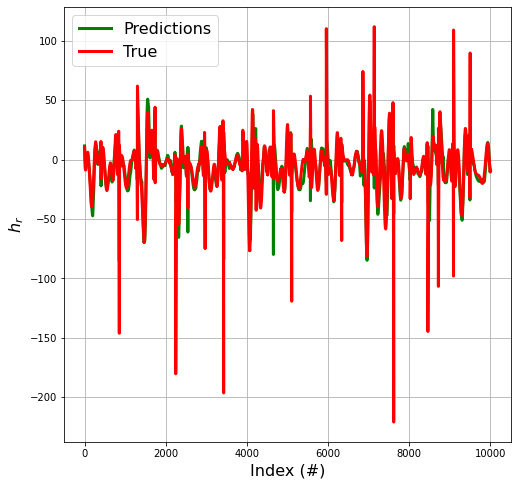

INFO:tensorflow:Assets written to: ../network_parameters/python_model/no_act/batch_L_s1_drift/assets
[[ 11.438273 ]
 [ 10.076767 ]
 [  9.419647 ]
 ...
 [-14.336287 ]
 [-15.1600685]
 [-15.791336 ]]
batch_L.csv
short side barrier
2 _layer, no act
Epoch 1/60
1787/1787 [==============================] - 1s 836us/step - loss: 16.3118 - val_loss: 14.7789
Epoch 2/60
1787/1787 [==============================] - 2s 871us/step - loss: 14.0725 - val_loss: 13.9719
Epoch 3/60
1787/1787 [==============================] - 2s 850us/step - loss: 13.3854 - val_loss: 13.3020
Epoch 4/60
1787/1787 [==============================] - 2s 872us/step - loss: 12.9459 - val_loss: 12.9204
Epoch 5/60
1787/1787 [==============================] - 2s 863us/step - loss: 12.7337 - val_loss: 12.6521
Epoch 6/60
1787/1787 [==============================] - 1s 833us/step - loss: 12.5707 - val_loss: 12.5877
Epoch 7/60
1787/1787 [==============================] - 2s 847us/step - loss: 12.4483 - val_loss: 12.5357
Epoch 8/60
17

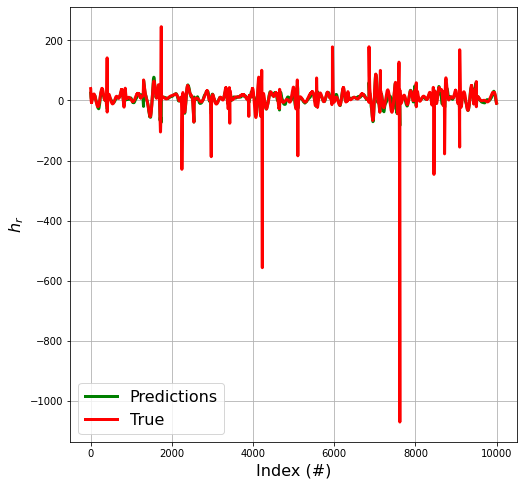

INFO:tensorflow:Assets written to: ../network_parameters/python_model/no_act/batch_L_s2_drift/assets
[[ 24.302101]
 [ 21.968288]
 [ 20.865337]
 ...
 [-27.62753 ]
 [-29.211544]
 [-31.316345]]


In [119]:
## Test with MSE residuals2 and adjusted gain
s1 = learned_model_2_layer_no_act_ISSF('batch_L.csv', "s1")
s1.num_epochs = 60
s1.load_model_eval_plot_and_save(10000)
print(s1.h_r_predictions)

## Test with MSE residuals2 and adjusted gain
s2 = learned_model_2_layer_no_act_ISSF('batch_L.csv', "s2")
s2.num_epochs = 60
s2.load_model_eval_plot_and_save(10000)
print(s2.h_r_predictions)

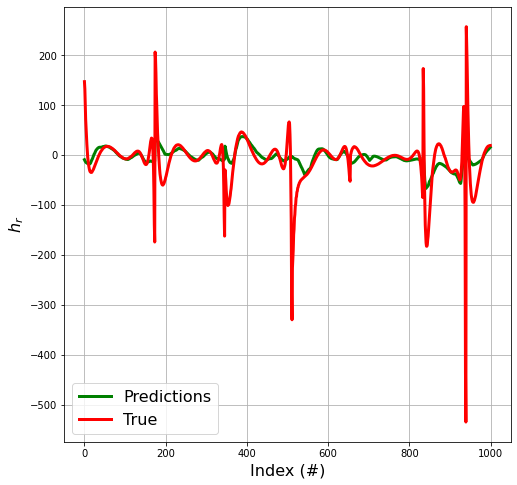

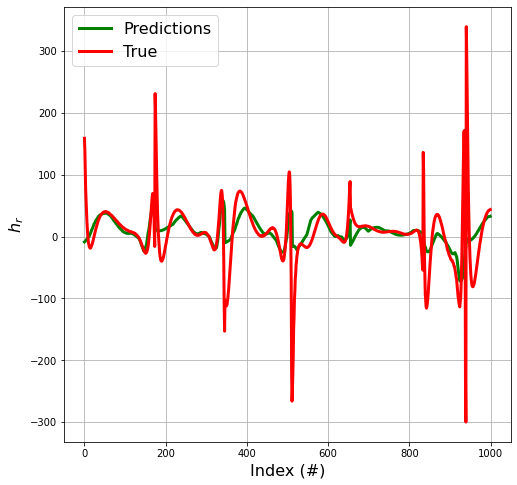

In [118]:
s1.plotter(1000)
s2.plotter(1000)

In [ ]:
## Test with MSE residuals and adjusted gain
s1_MSE_res1 = learned_model_2_layer('batch_sim.csv', "s1")
s1_MSE_res1.num_epochs = 10
s1_MSE_res1.regularization_weight = 0.5
s1_MSE_res1.regularization ="custom"
s1_MSE_res1.load_model_eval_plot_and_save(7500)
s1_MSE_res1.compare_projections(7500)

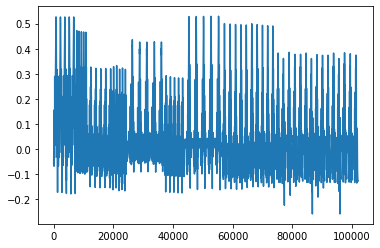

In [59]:
plt.figure()
plt.plot(s1_MSE_res1.drift_predictions)

batch_sim.csv
short side barrier
2 layer model
Using Custom Regularization 1
Epoch 1/10
102114/102114 [==============================] - 24s 237us/step - loss: 68.9900
Epoch 2/10
102114/102114 [==============================] - 23s 228us/step - loss: 11.8941
Epoch 3/10
102114/102114 [==============================] - 23s 228us/step - loss: 7.5502
Epoch 4/10
102114/102114 [==============================] - 23s 226us/step - loss: 6.5989
Epoch 5/10
102114/102114 [==============================] - 24s 230us/step - loss: 6.0848
Epoch 6/10
102114/102114 [==============================] - 23s 229us/step - loss: 5.6996
Epoch 7/10
102114/102114 [==============================] - 23s 228us/step - loss: 5.4137
Epoch 8/10
102114/102114 [==============================] - 23s 228us/step - loss: 5.2975
Epoch 9/10
102114/102114 [==============================] - 23s 229us/step - loss: 5.1133
Epoch 10/10
102114/102114 [==============================] - 23s 228us/step - loss: 4.9728


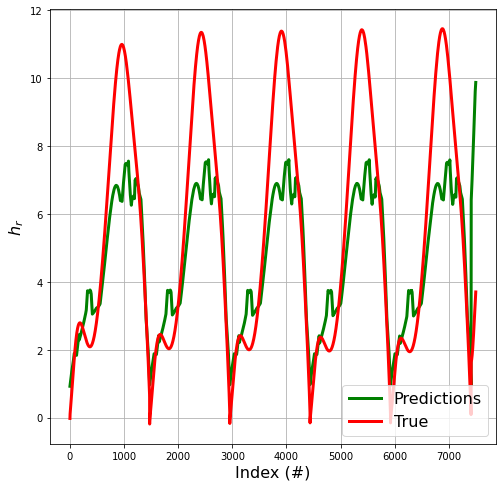

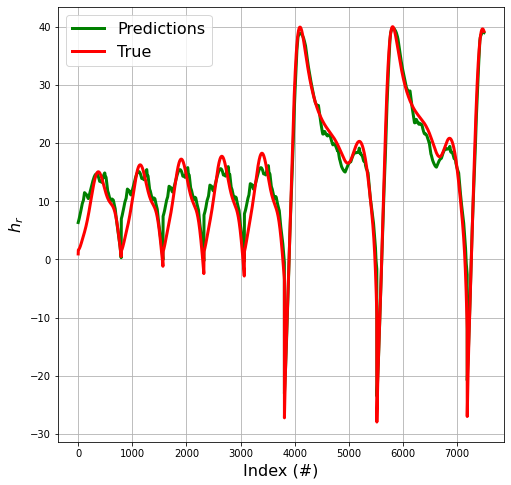

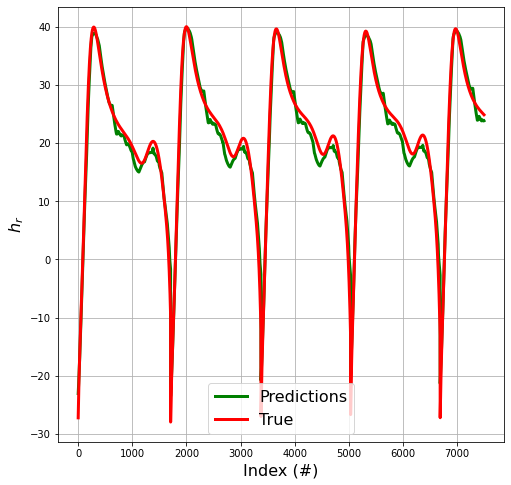

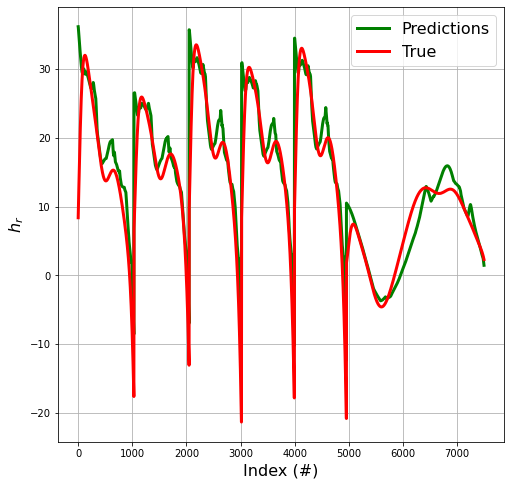

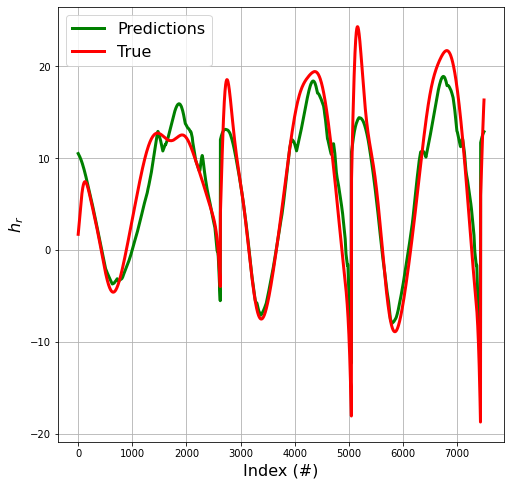

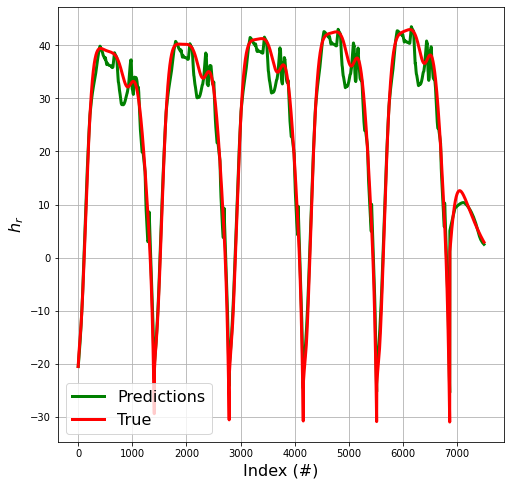

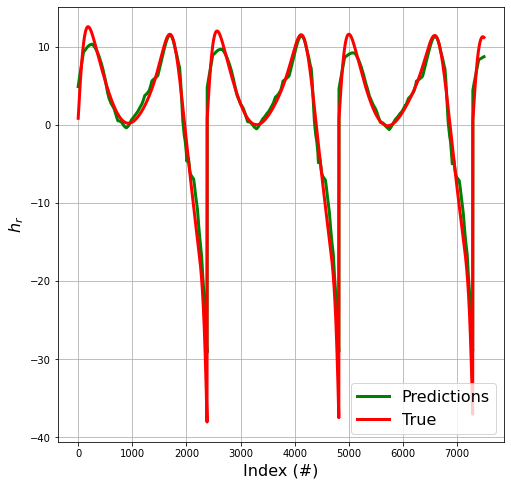

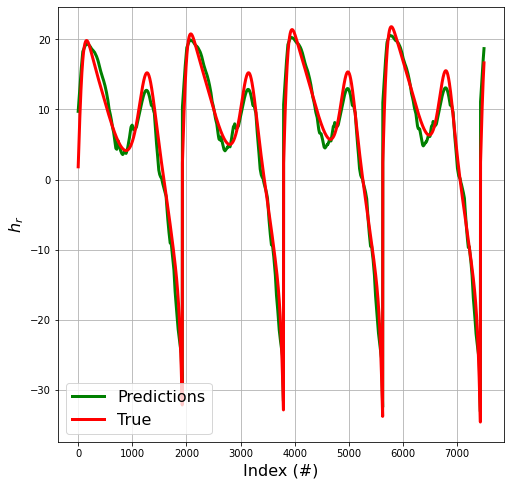

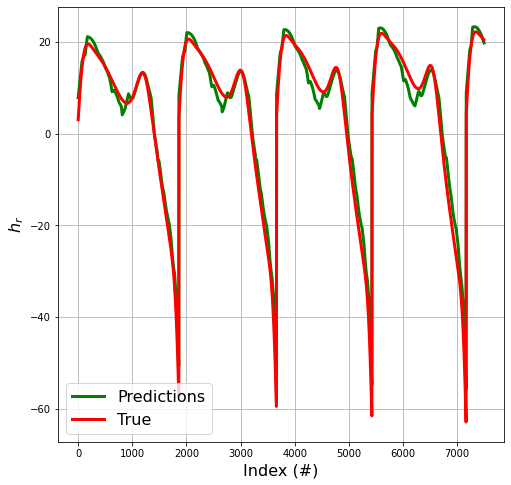

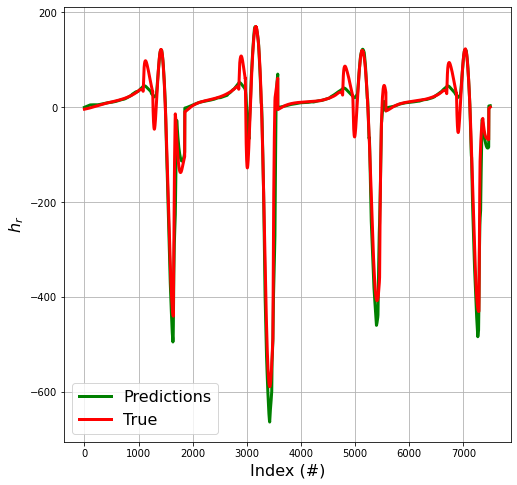

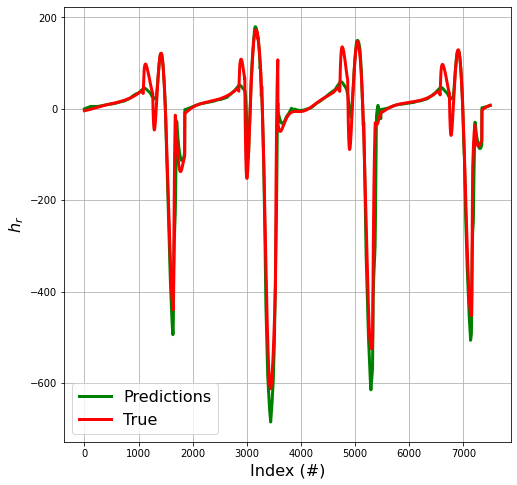

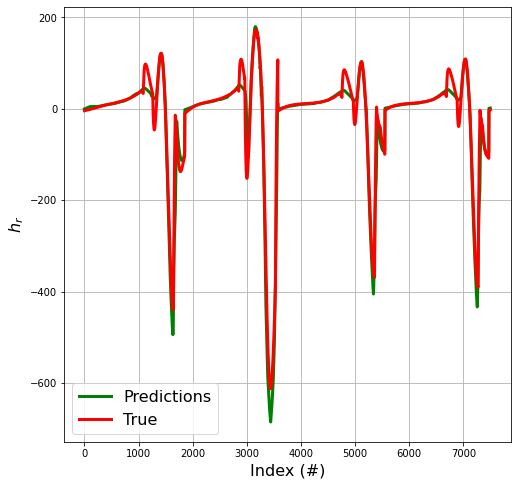

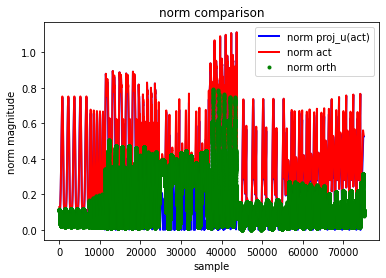

In [8]:
s2_MSE_res1 = learned_model_2_layer('batch_sim.csv', "s2")
s1_MSE_res1.num_epochs =5
s2_MSE_res1.regularization_weight = 0.5
s2_MSE_res1.regularization ="custom"
s2_MSE_res1.load_model_eval_plot_and_save(7500)
s2_MSE_res1.compare_projections(7500)

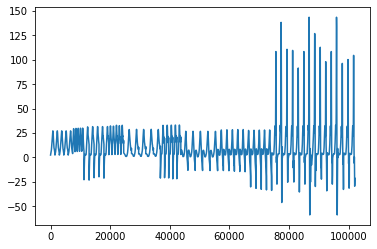

In [60]:
plt.figure()
plt.plot(s2_MSE_res1.drift_predictions)

Text(0.5, 1.0, 'S2 Drift')

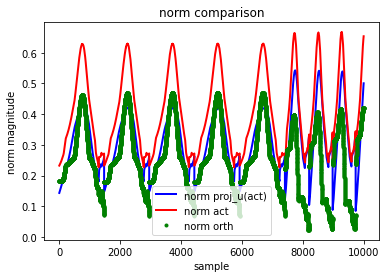

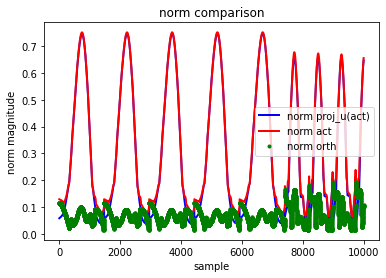

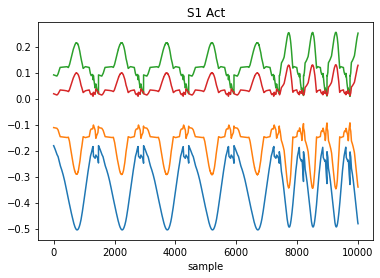

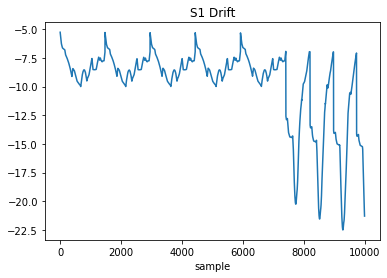

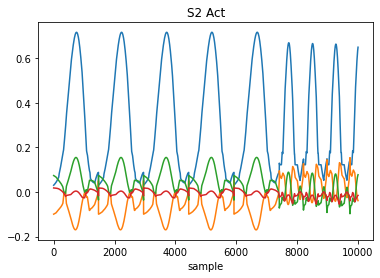

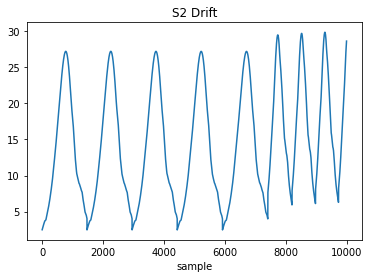

In [9]:
start = 0
end = 10000

s1_MSE_res1.compare_projections(10000)
s2_MSE_res1.compare_projections(10000)

plt.figure()
plt.plot(s1_MSE_res1.act_predictions[start:end, 0, 0])
plt.plot(s1_MSE_res1.act_predictions[start:end, 0, 1])
plt.plot(s1_MSE_res1.act_predictions[start:end, 0, 2])
plt.plot(s1_MSE_res1.act_predictions[start:end, 0, 3])
plt.xlabel('sample')
plt.title('S1 Act')

plt.figure()
plt.plot(s1_MSE_res1.drift_predictions[start:end])
plt.xlabel('sample')
plt.title('S1 Drift')

plt.figure()
plt.plot(s2_MSE_res1.act_predictions[start:end, 0, 0])
plt.plot(s2_MSE_res1.act_predictions[start:end, 0, 1])
plt.plot(s2_MSE_res1.act_predictions[start:end, 0, 2])
plt.plot(s2_MSE_res1.act_predictions[start:end, 0, 3])
plt.xlabel('sample')
plt.title('S2 Act')

plt.figure()
plt.plot(s2_MSE_res1.drift_predictions[start:end])
plt.xlabel('sample')
plt.title('S2 Drift')

batch_sim.csv
long side barrier
2 _layer, no act
Epoch 1/10
102114/102114 [==============================] - 11s 107us/step - loss: 17.4718
Epoch 2/10
102114/102114 [==============================] - 10s 102us/step - loss: 10.0822
Epoch 3/10
102114/102114 [==============================] - 10s 103us/step - loss: 7.8508
Epoch 4/10
102114/102114 [==============================] - 10s 102us/step - loss: 6.5739
Epoch 5/10
102114/102114 [==============================] - 10s 102us/step - loss: 6.0481
Epoch 6/10
102114/102114 [==============================] - 10s 102us/step - loss: 5.5436
Epoch 7/10
102114/102114 [==============================] - 10s 102us/step - loss: 5.3287
Epoch 8/10
102114/102114 [==============================] - 10s 102us/step - loss: 4.9977
Epoch 9/10
102114/102114 [==============================] - 11s 103us/step - loss: 4.8554
Epoch 10/10
102114/102114 [==============================] - 10s 103us/step - loss: 4.6221


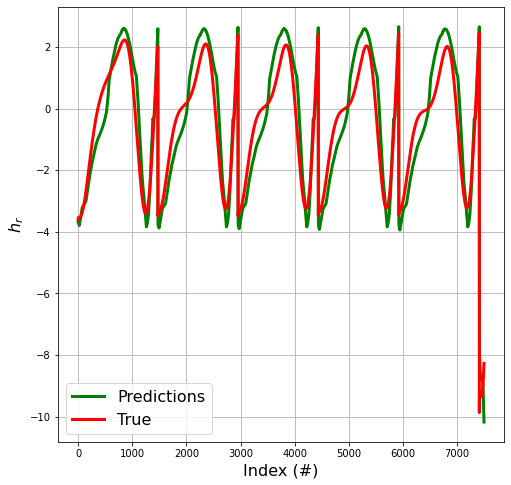

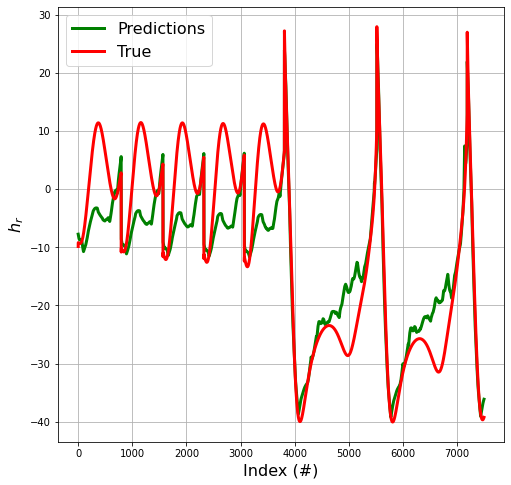

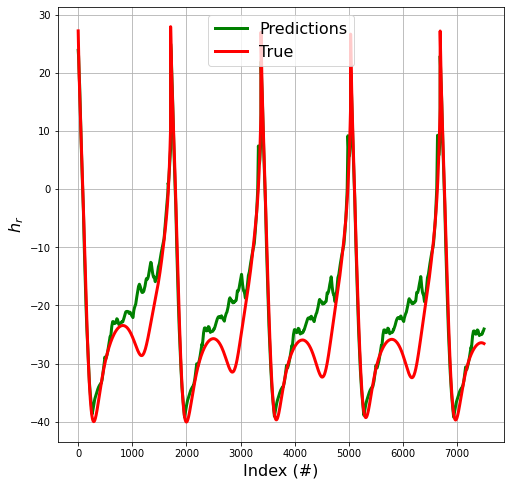

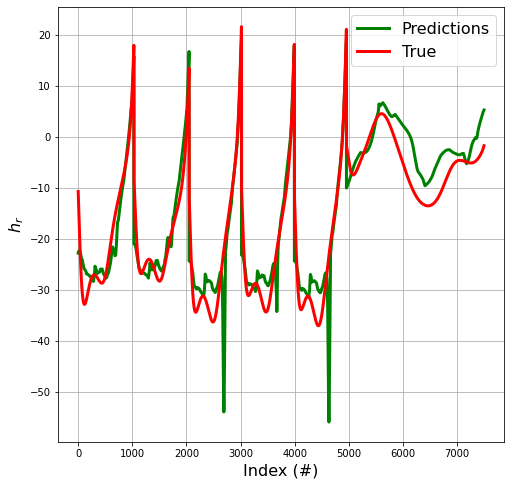

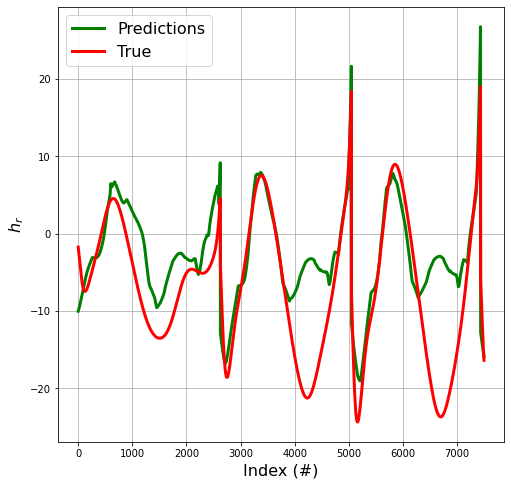

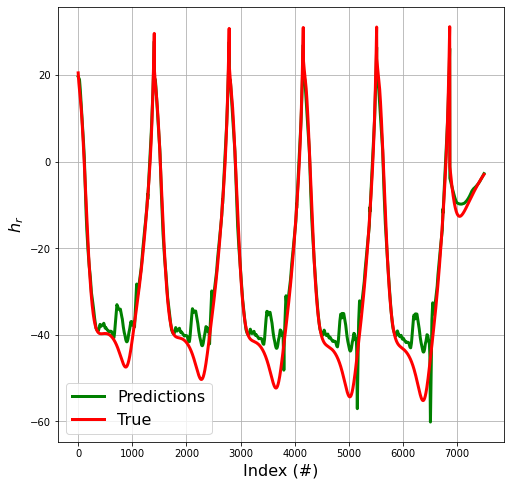

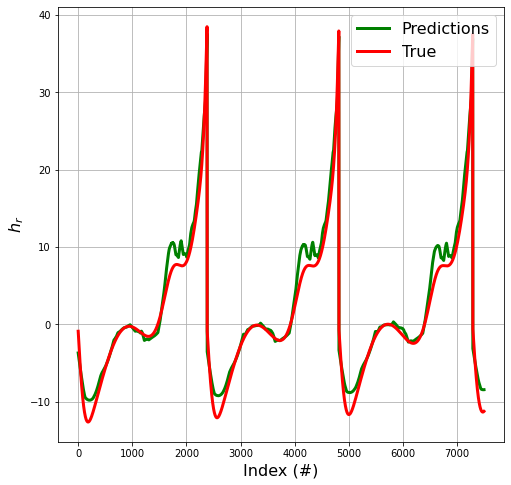

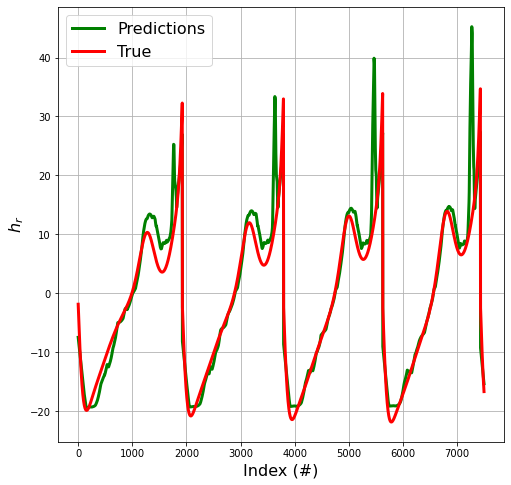

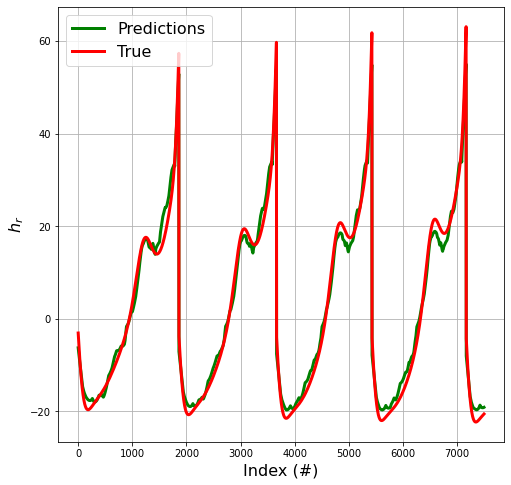

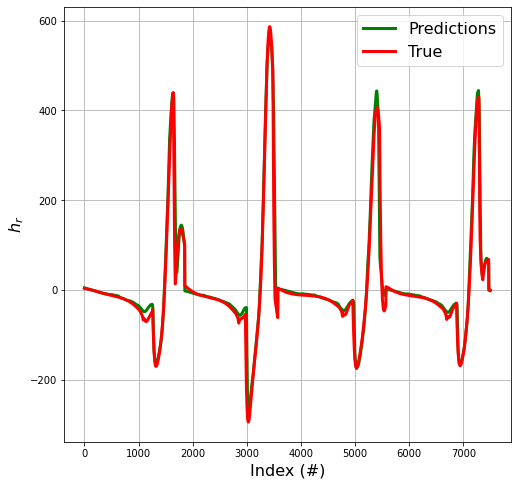

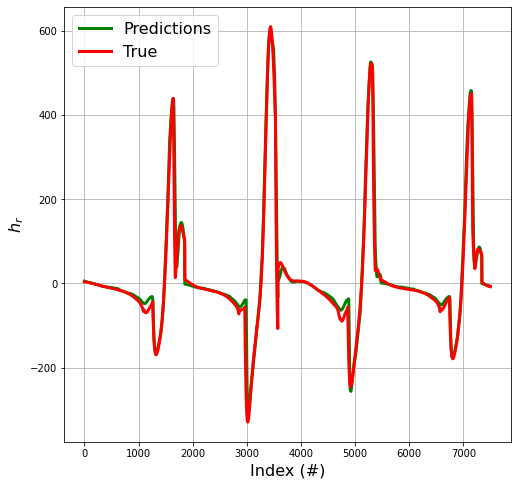

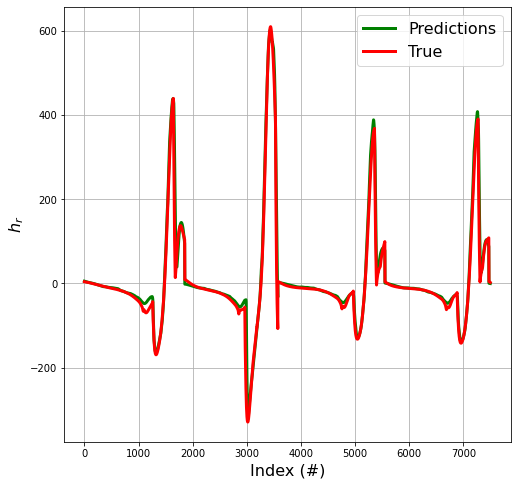

batch_sim.csv
short side barrier
2 _layer, no act


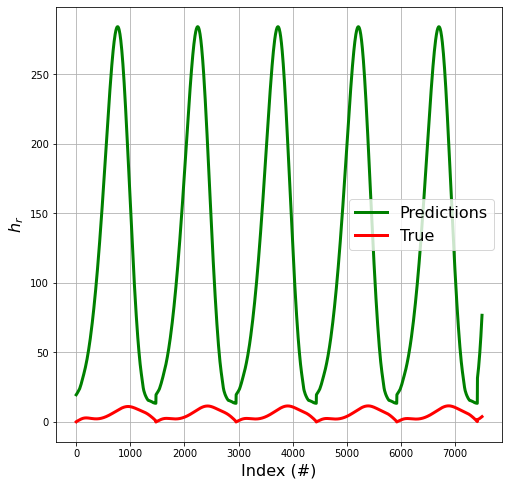

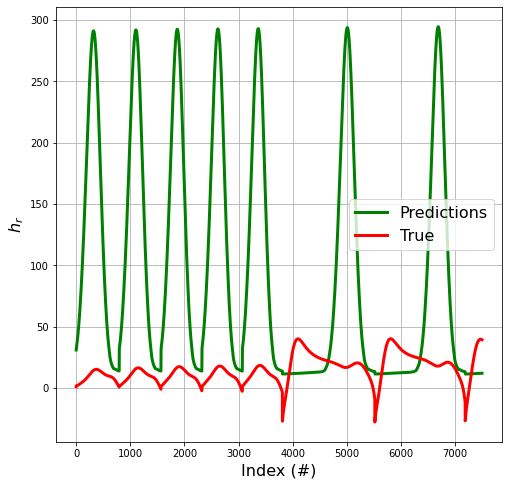

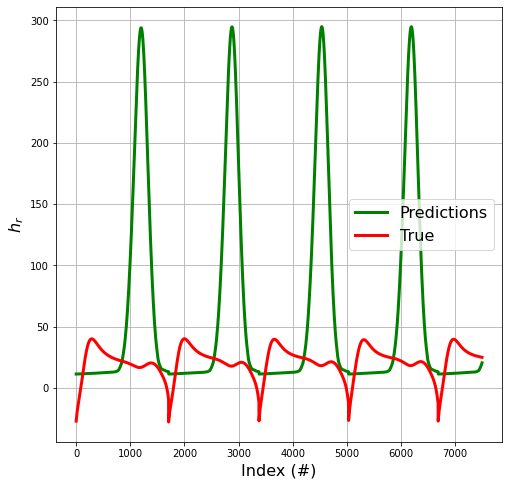

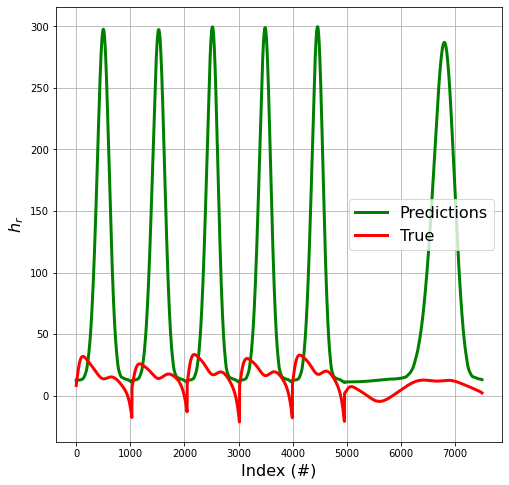

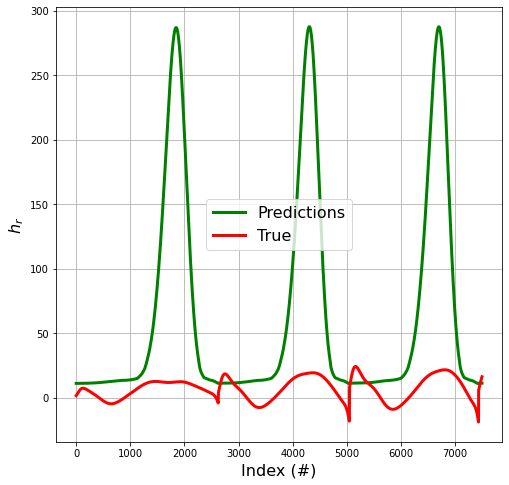

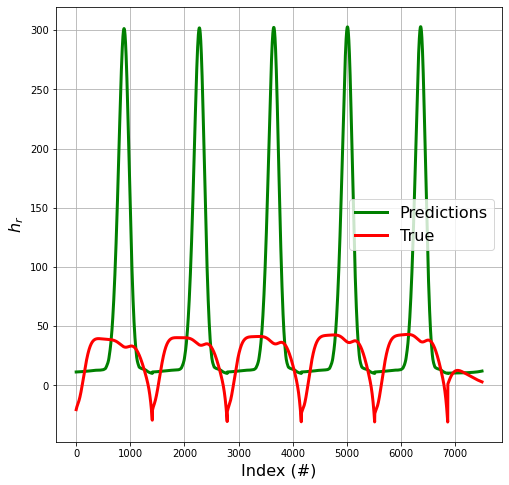

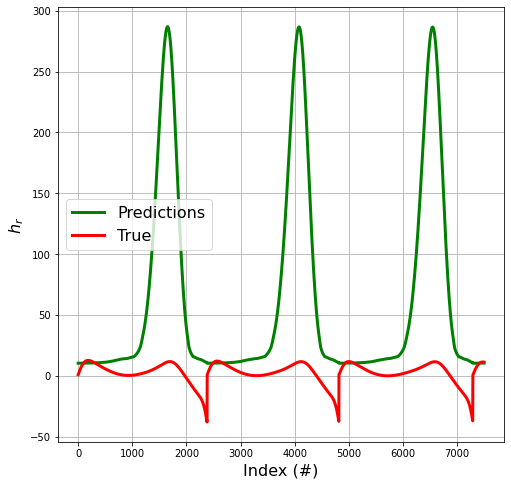

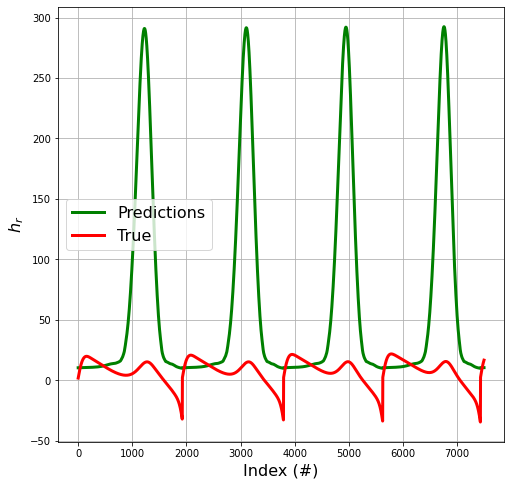

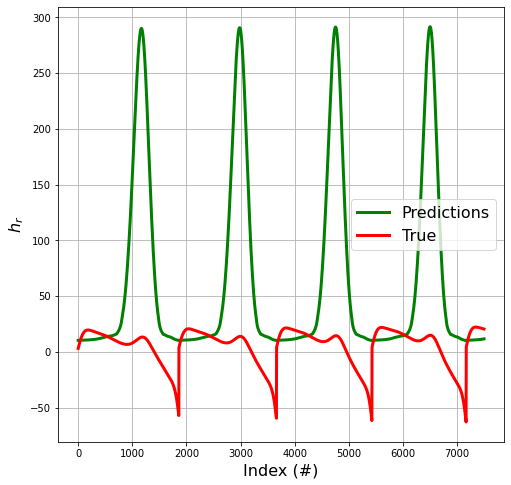

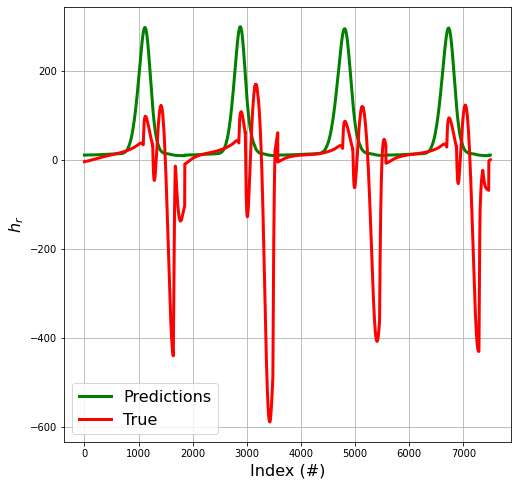

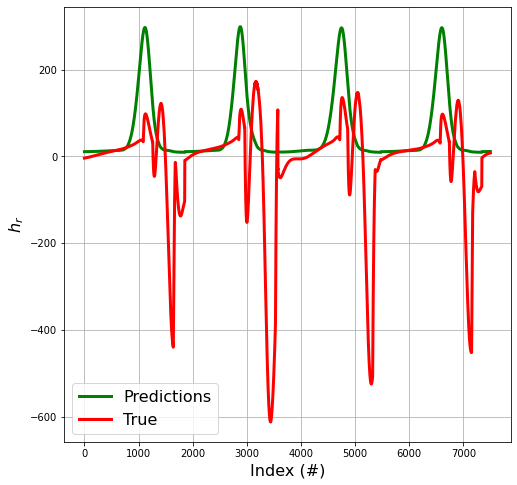

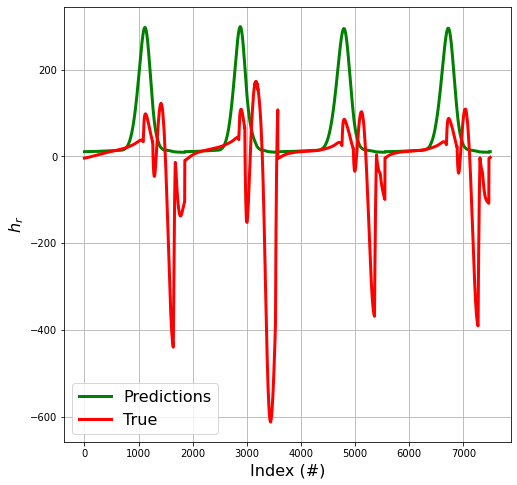

In [11]:
s1_no_act = learned_model_2_layer_no_act('batch_sim.csv', "s1")
s1_no_act.d_hidden = 100
s1_no_act.num_epochs = 10
s1_no_act.load_model_eval_plot_and_save(7500)

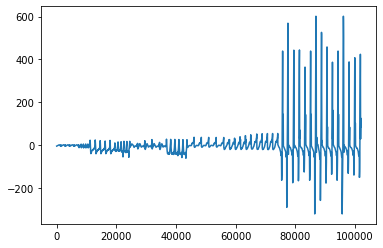

In [63]:
plt.figure()
plt.plot(s1_no_act.h_r_predictions)

batch_sim.csv
short side barrier
2 _layer, no act
Epoch 1/10
102114/102114 [==============================] - 11s 110us/step - loss: 15.3319
Epoch 2/10
102114/102114 [==============================] - 11s 109us/step - loss: 9.1733
Epoch 3/10
102114/102114 [==============================] - 11s 109us/step - loss: 7.1307
Epoch 4/10
102114/102114 [==============================] - 11s 110us/step - loss: 6.2454
Epoch 5/10
102114/102114 [==============================] - 11s 108us/step - loss: 5.7290
Epoch 6/10
102114/102114 [==============================] - 11s 108us/step - loss: 5.3580
Epoch 7/10
102114/102114 [==============================] - 11s 110us/step - loss: 4.9729
Epoch 8/10
102114/102114 [==============================] - 11s 110us/step - loss: 4.6949
Epoch 9/10
102114/102114 [==============================] - 11s 107us/step - loss: 4.5097
Epoch 10/10
102114/102114 [==============================] - 11s 107us/step - loss: 4.3077


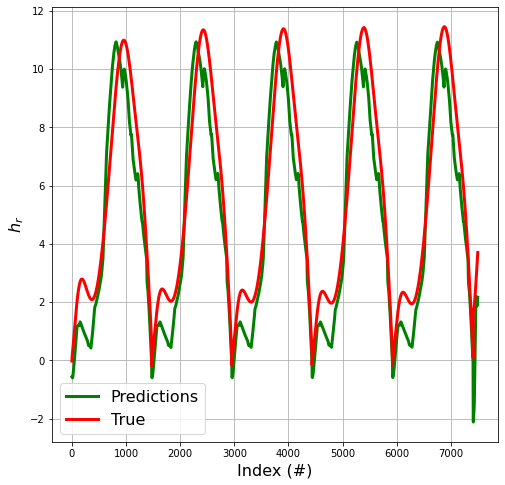

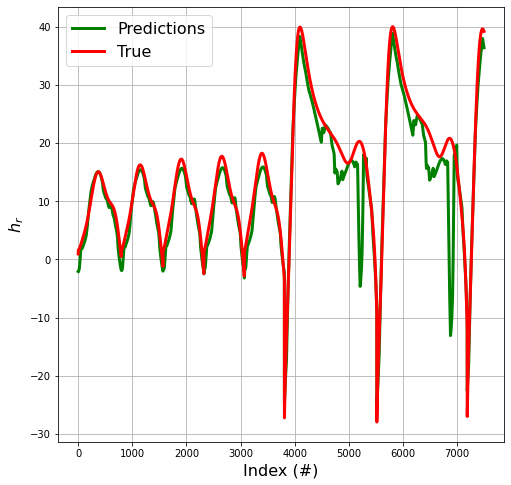

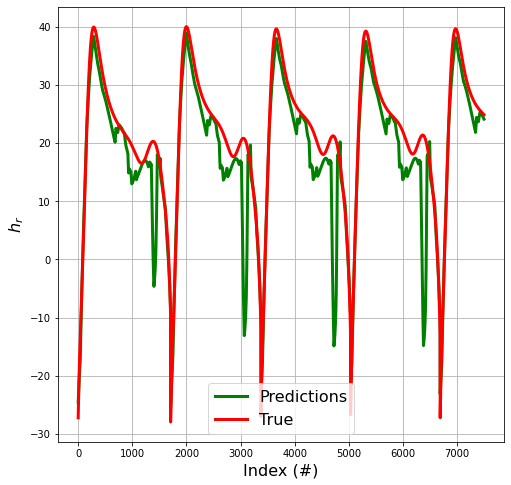

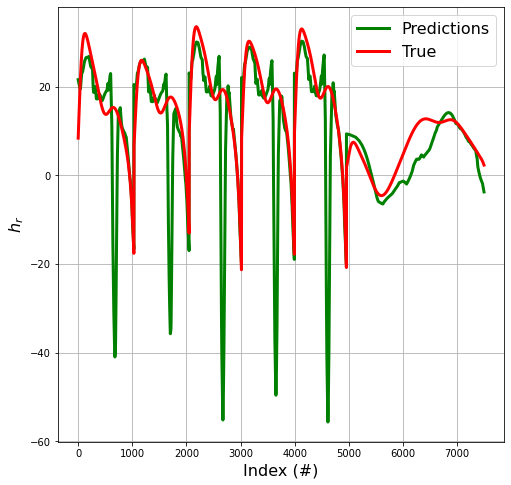

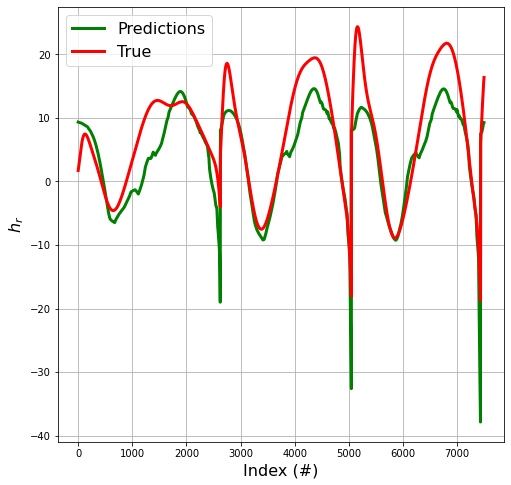

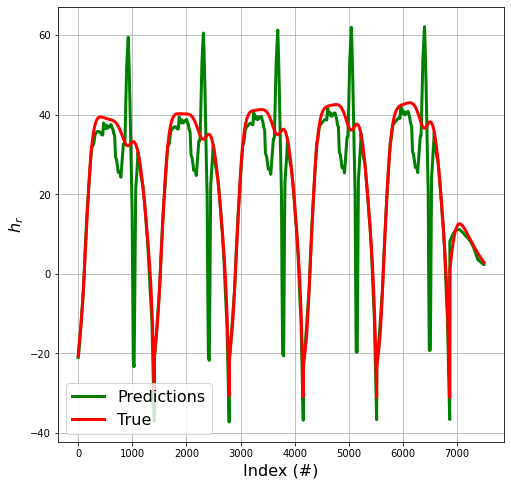

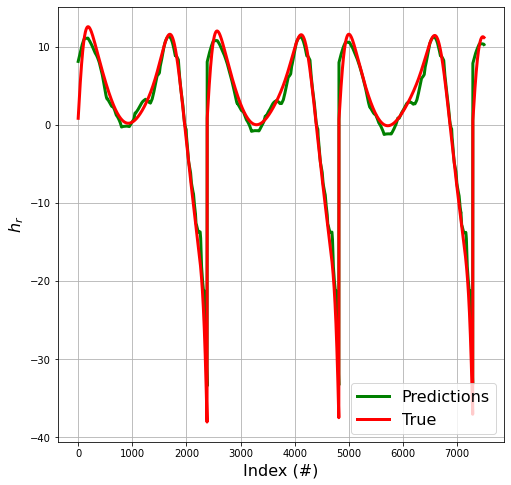

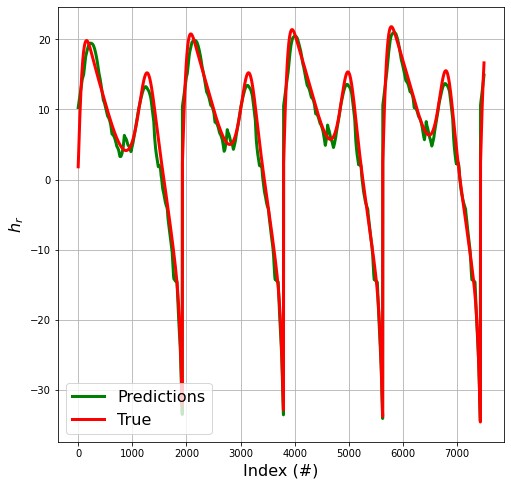

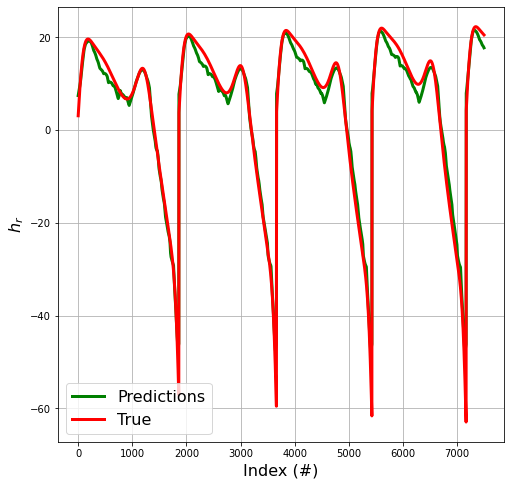

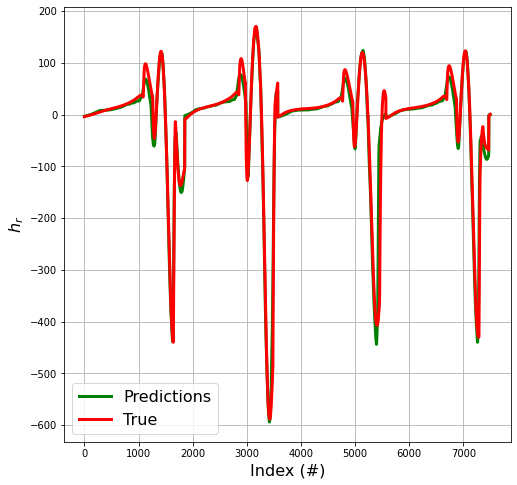

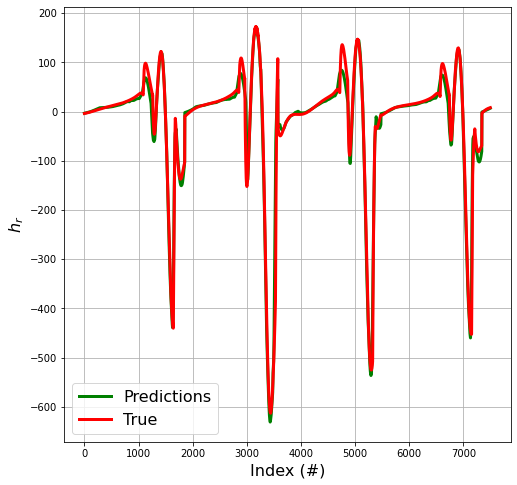

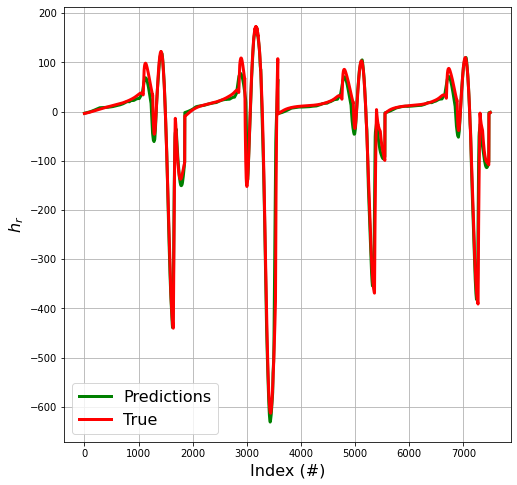

In [12]:
s2_no_act = learned_model_2_layer_no_act('batch_sim.csv', "s2")
s2_no_act.d_hidden = 100
s2_no_act.num_epochs = 10
s2_no_act.load_model_eval_plot_and_save(7500)

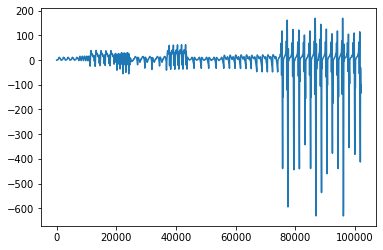

In [64]:
plt.figure()
plt.plot(s2_no_act.h_r_predictions)

batch_L.csv
long side barrier
2 _layer, no act
Epoch 1/20
56935/56935 [==============================] - 12s 209us/step - loss: 51.0471
Epoch 2/20
56935/56935 [==============================] - 10s 174us/step - loss: 46.9272
Epoch 3/20
56935/56935 [==============================] - 10s 174us/step - loss: 45.9242
Epoch 4/20
56935/56935 [==============================] - 10s 176us/step - loss: 44.8651
Epoch 5/20
56935/56935 [==============================] - 10s 175us/step - loss: 43.5005
Epoch 6/20
56935/56935 [==============================] - 10s 176us/step - loss: 42.1069
Epoch 7/20
56935/56935 [==============================] - 10s 178us/step - loss: 40.8911
Epoch 8/20
56935/56935 [==============================] - 10s 178us/step - loss: 39.7938
Epoch 9/20
56935/56935 [==============================] - 10s 176us/step - loss: 38.9069
Epoch 10/20
56935/56935 [==============================] - 10s 175us/step - loss: 37.9123
Epoch 11/20
56935/56935 [==============================] - 10s

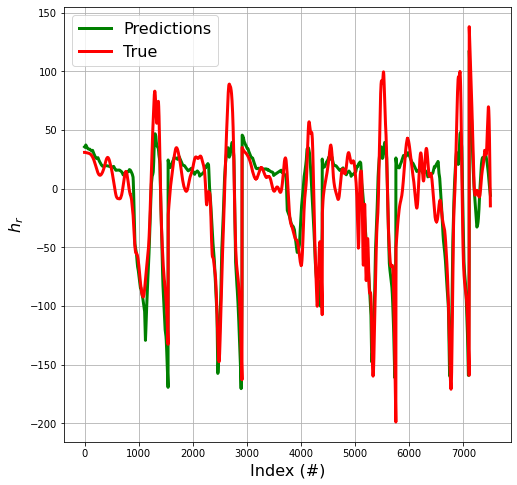

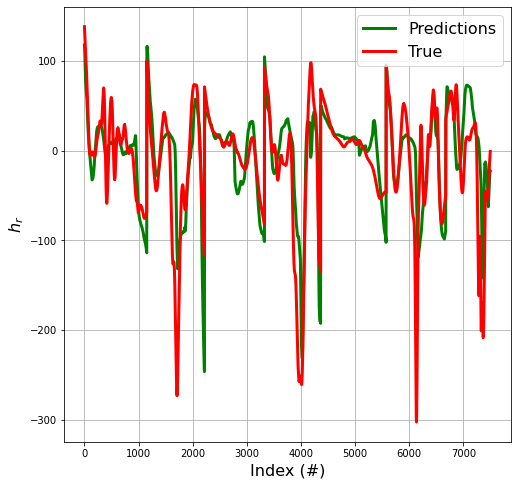

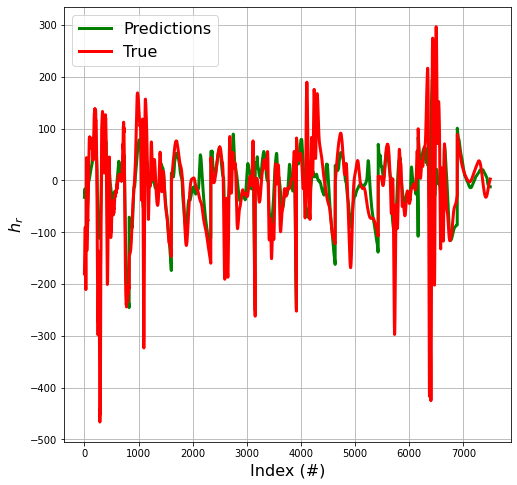

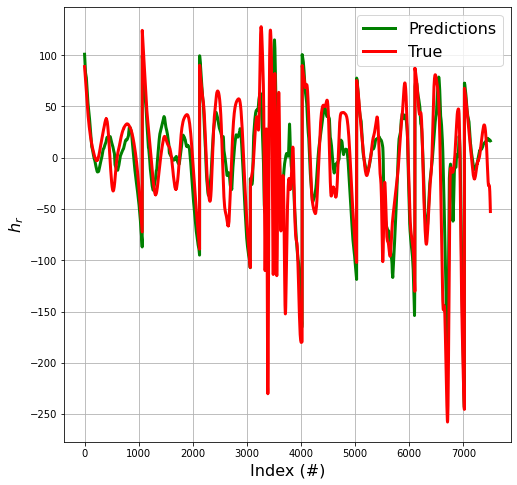

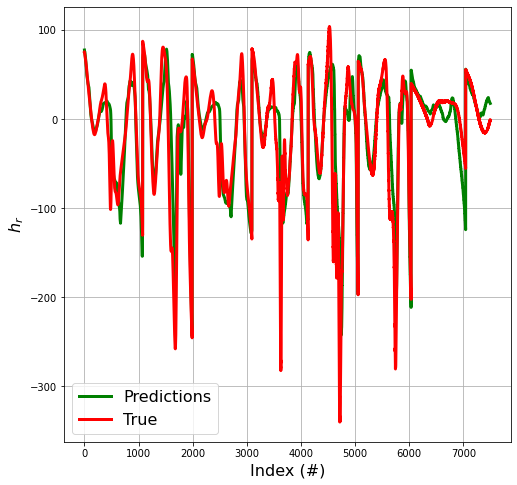

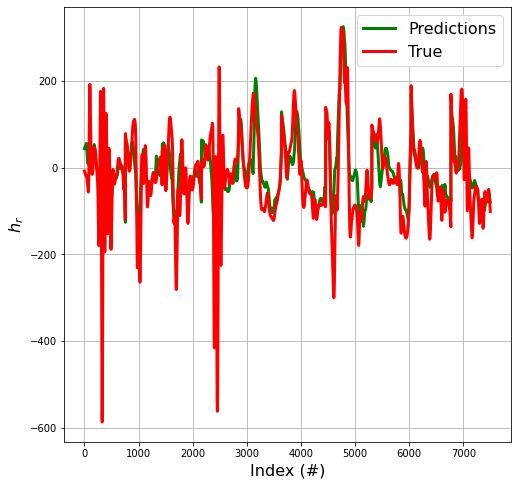

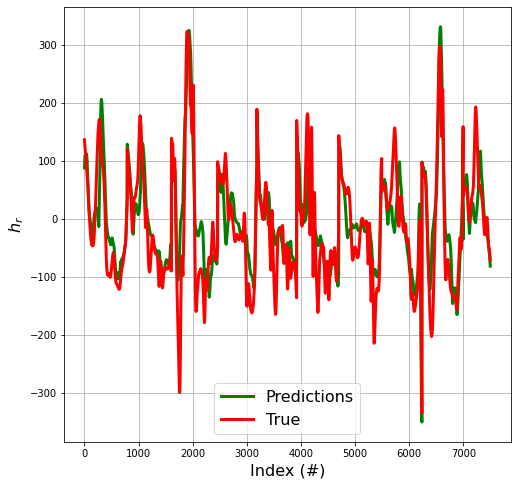

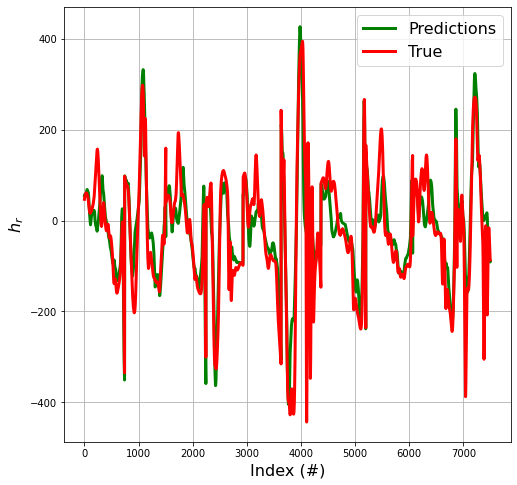

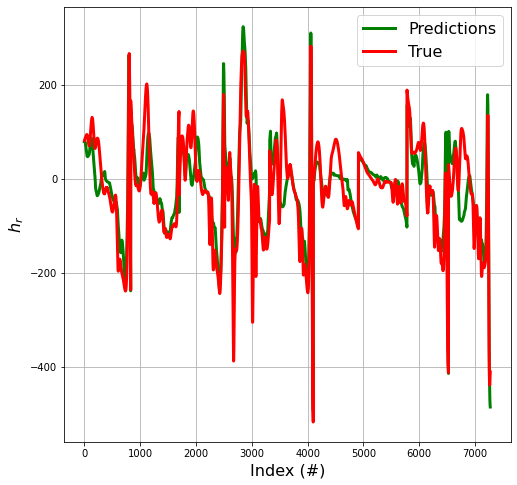

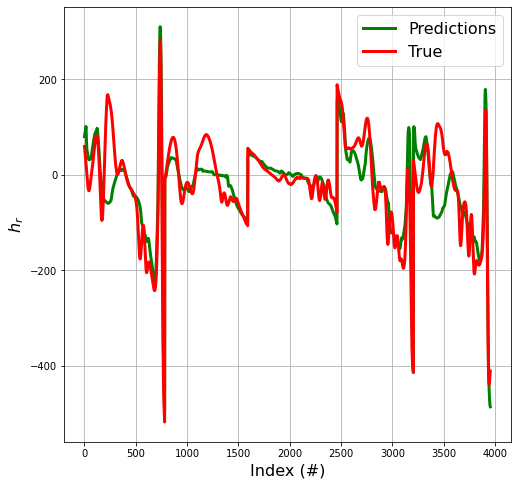

[[0. 0. 0. 0.]]
batch_L.csv
short side barrier
2 _layer, no act
Epoch 1/20
56935/56935 [==============================] - 12s 207us/step - loss: 53.7250
Epoch 2/20
56935/56935 [==============================] - 10s 175us/step - loss: 48.3546
Epoch 3/20
56935/56935 [==============================] - 10s 174us/step - loss: 47.0811
Epoch 4/20
56935/56935 [==============================] - 10s 183us/step - loss: 46.2369
Epoch 5/20
56935/56935 [==============================] - 11s 187us/step - loss: 45.5073
Epoch 6/20
56935/56935 [==============================] - 10s 179us/step - loss: 44.6181
Epoch 7/20
56935/56935 [==============================] - 10s 180us/step - loss: 44.0779
Epoch 8/20
56935/56935 [==============================] - 10s 178us/step - loss: 43.4208
Epoch 9/20
56935/56935 [==============================] - 10s 178us/step - loss: 42.7481
Epoch 10/20
56935/56935 [==============================] - 10s 178us/step - loss: 42.0653
Epoch 11/20
56935/56935 [====================

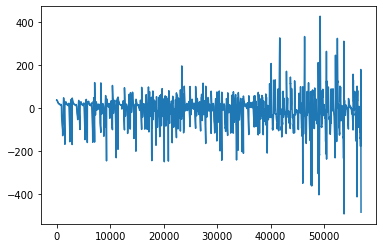

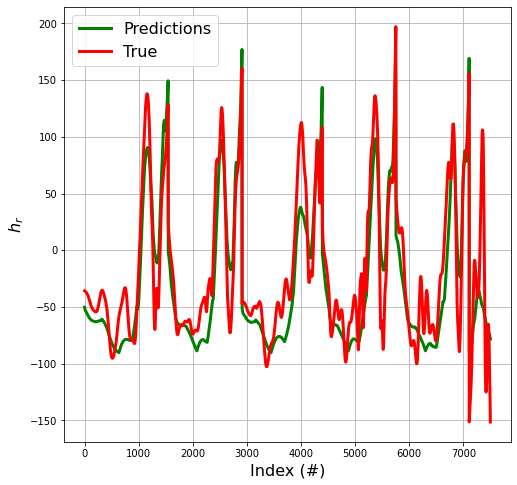

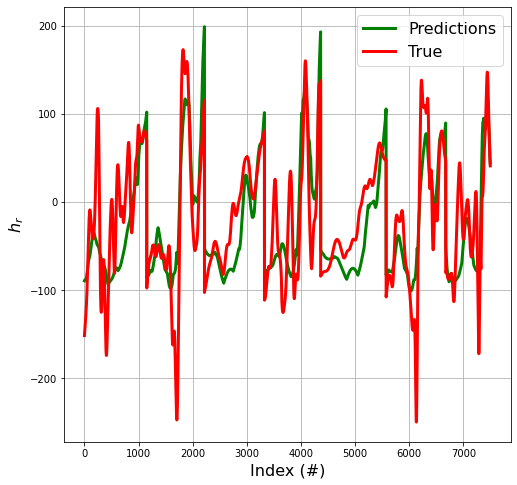

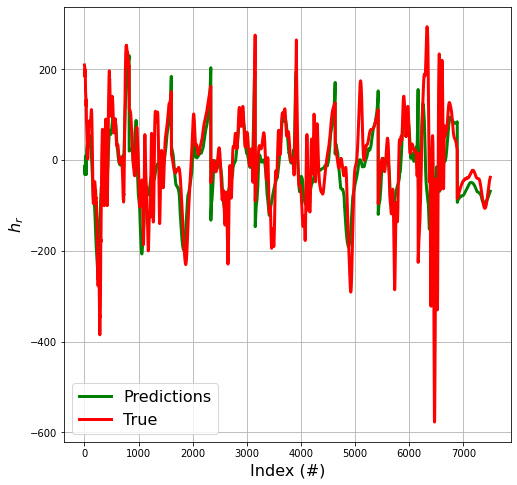

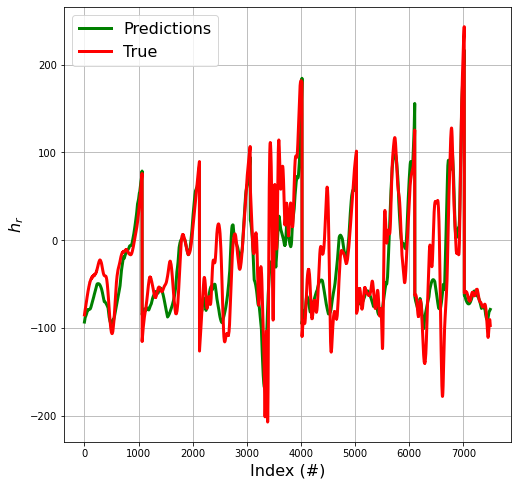

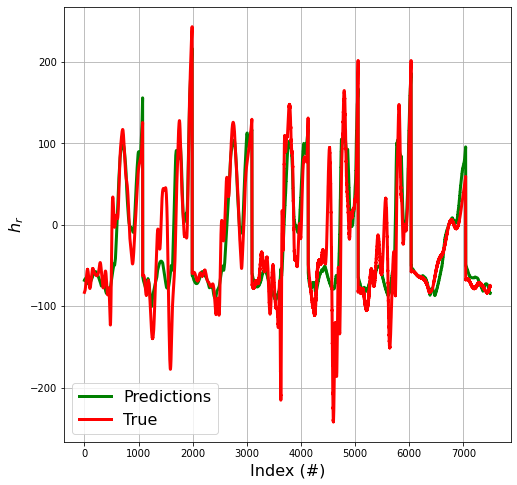

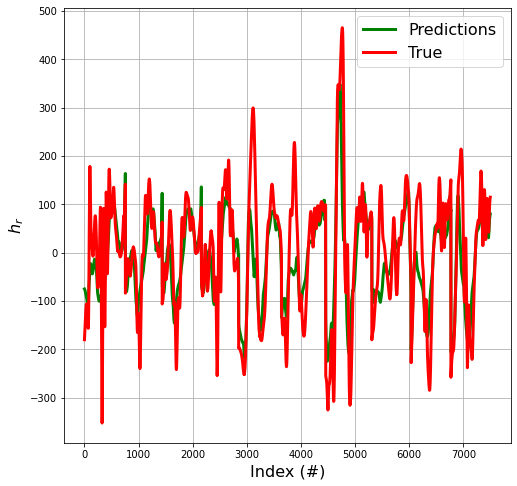

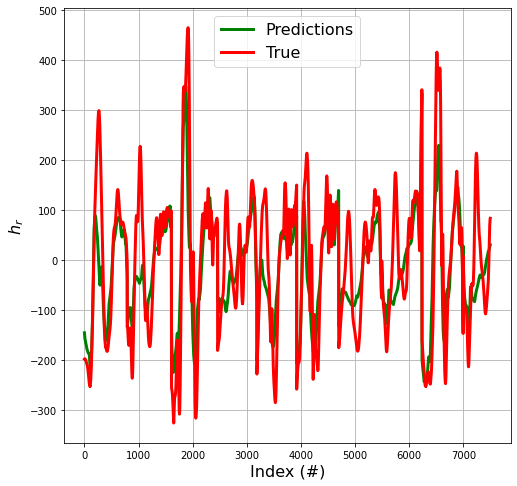

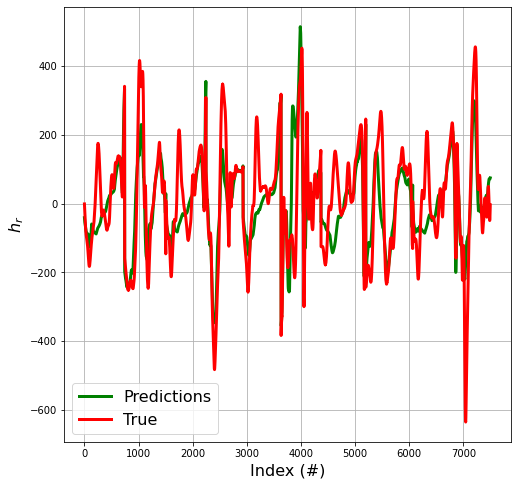

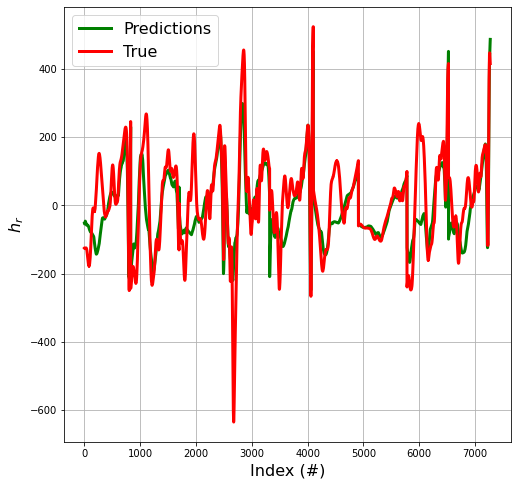

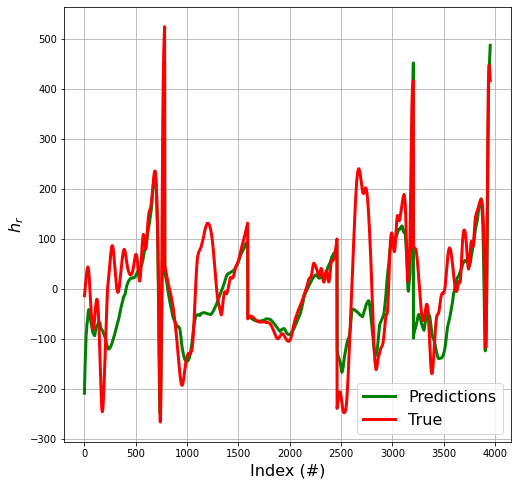

[[0. 0. 0. 0.]]


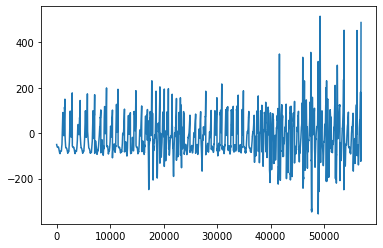

In [72]:
## REAL DATA
s1_no_act_real = learned_model_2_layer_no_act('batch_L.csv', "s1")
s1_no_act_real.d_hidden = 100
s1_no_act_real.num_epochs = 20
s1_no_act_real.load_model_eval_plot_and_save(7500)
plt.figure()
plt.plot(s1_no_act_real.h_r_predictions)



s2_no_act_real = learned_model_2_layer_no_act('batch_L.csv', "s2")
s2_no_act_real.d_hidden = 100
s2_no_act_real.num_epochs = 20
s2_no_act_real.load_model_eval_plot_and_save(7500)
plt.figure()
plt.plot(s2_no_act_real.h_r_predictions)

Text(0.5, 1.0, 'norm comparison')

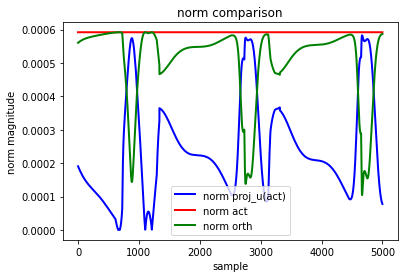

In [13]:
# Evaluate Model
acts =h_model_Ls1.act_predictions
us = h_model_Ls1.control_data
act_proj_norm = []
act_norm = []
act_orth_norm = []
for i in range(len(acts)): 
    act_proj_norm.append(np.linalg.norm((acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,:]))
    act_norm.append(np.linalg.norm(acts[i,:]))
    act_orth_norm.append(np.linalg.norm(acts[i,:]-(acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,:]) )

plt.figure()
plt.plot(act_proj_norm[95000:100000], 'b', linewidth=2)
plt.plot(act_norm[95000:100000], 'r', linewidth=2)
plt.plot(act_orth_norm[95000:100000], 'g', linewidth=2)
plt.legend(['norm proj_u(act)', 'norm act', 'norm orth'])
plt.xlabel('sample')
plt.ylabel('norm magnitude')
plt.title('norm comparison')

Text(0.5, 1.0, 'norm comparison')

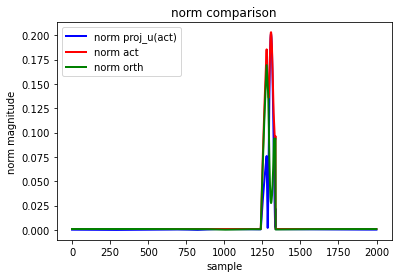

In [15]:
# Evaluate Model
acts =h_model_Ls2.act_predictions
us = h_model_Ls2.control_data
act_proj_norm = []
act_norm = []
act_orth_norm = []
for i in range(len(acts)): 
    act_proj_norm.append(np.linalg.norm((acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,:]))
    act_norm.append(np.linalg.norm(acts[i,:]))
    act_orth_norm.append(np.linalg.norm(acts[i,:]-(acts[i,:]@us[i,:].T)/(us[i,:]@us[i,:])*us[i,:]) )

plt.figure()
plt.plot(act_proj_norm[95000:97000], 'b', linewidth=2)
plt.plot(act_norm[95000:97000], 'r', linewidth=2)
plt.plot(act_orth_norm[95000:97000], 'g', linewidth=2)
plt.legend(['norm proj_u(act)', 'norm act', 'norm orth'])
plt.xlabel('sample')
plt.ylabel('norm magnitude')
plt.title('norm comparison')

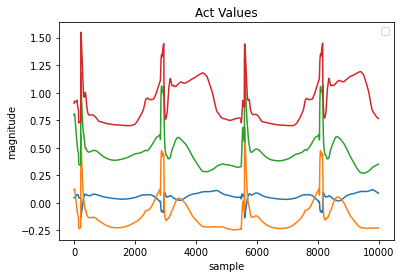

In [93]:
plt.plot(act_predictions[10:10000,0,:])
title('Act Values')
xlabel('sample')
ylabel('magnitude')
legend('')

Text(0.5, 1.0, 'Drift Values')

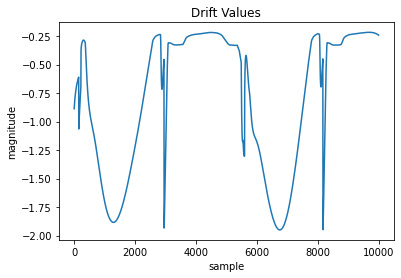

In [94]:
plot(drift_predictions[10:10000])
xlabel('sample')
ylabel('magnitude')
title('Drift Values')

Text(0.5, 1.0, '$u_{des}$, motor shaft torque')

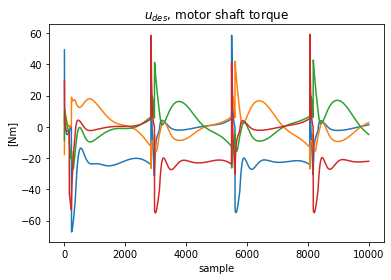

In [95]:
plot(control_data[1:10000, :])
xlabel('sample')
ylabel('[Nm]')
title('$u_{des}$, motor shaft torque')

In [96]:
A = np.zeros((len(control_data), 1))
for i in range(len(control_data)):
    A[i] = np.dot(act_predictions[i, 0, :],control_data[i,:])

Text(0.5, 0, 'samples')

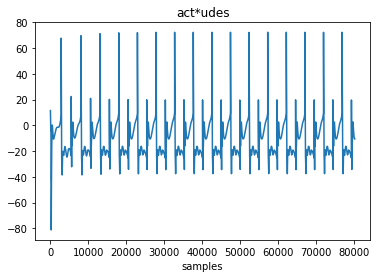

In [97]:
plot(A[10:-1])
title('act*udes')
xlabel('samples')



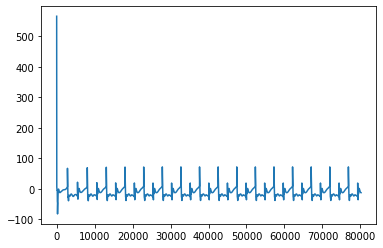

In [98]:
plot((drift_predictions + A))

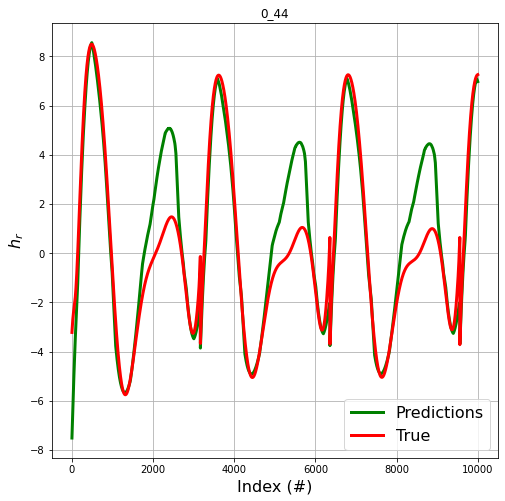

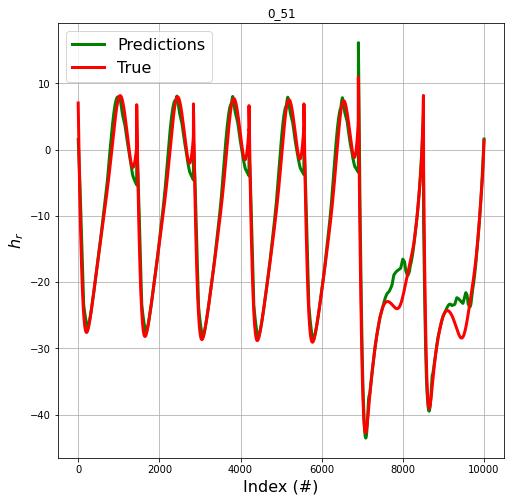

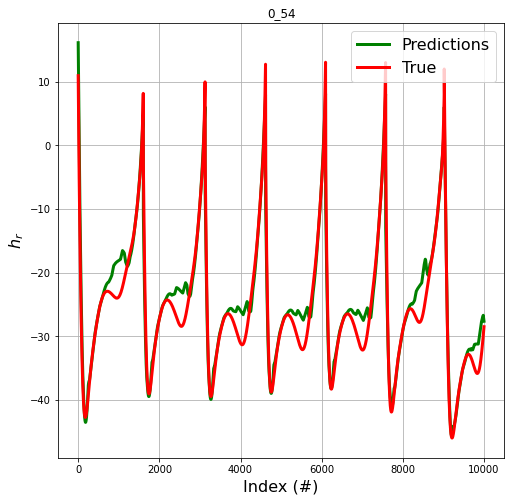

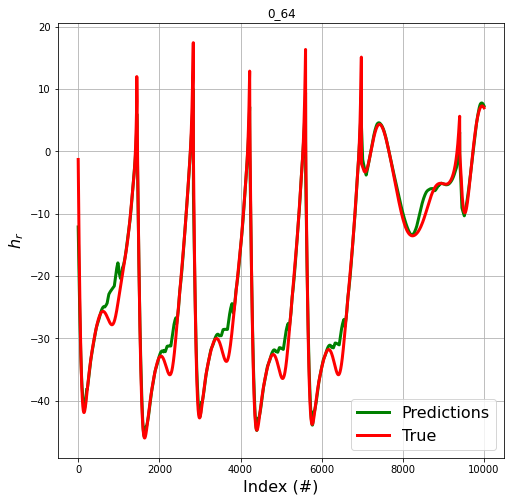

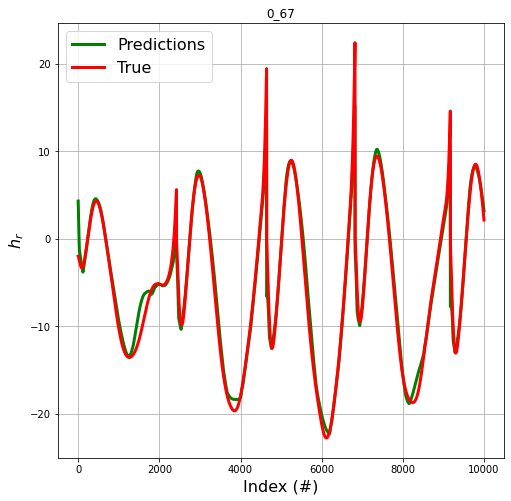

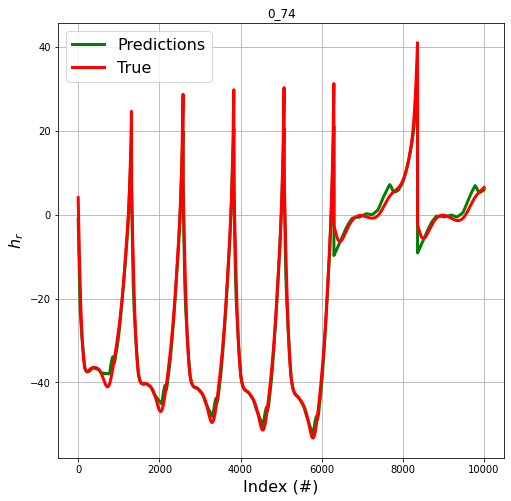

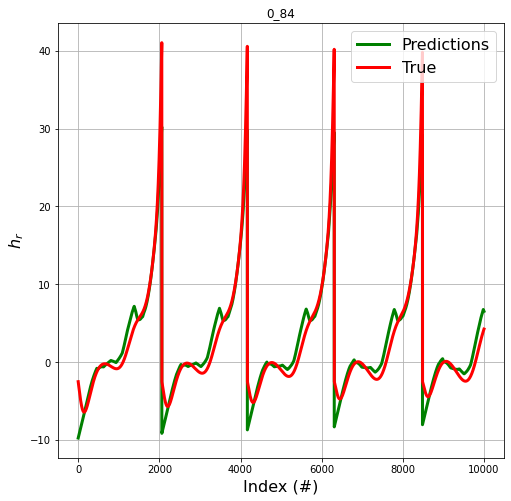

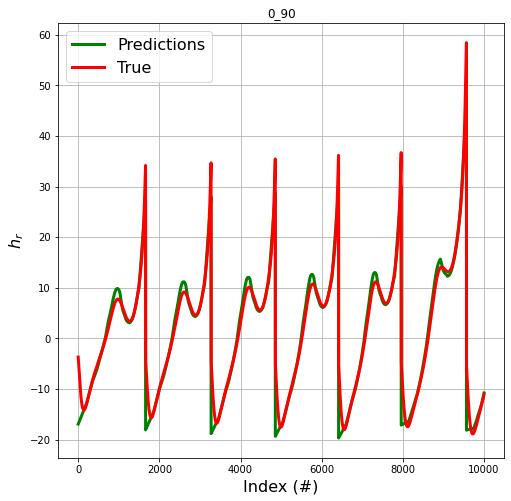

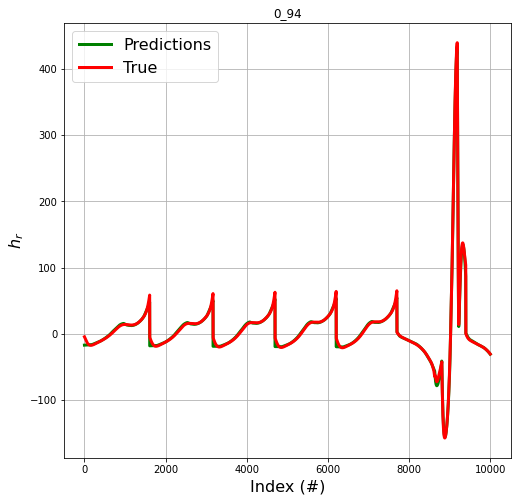

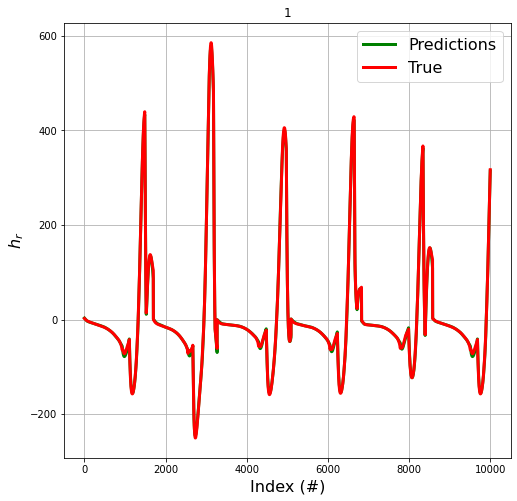

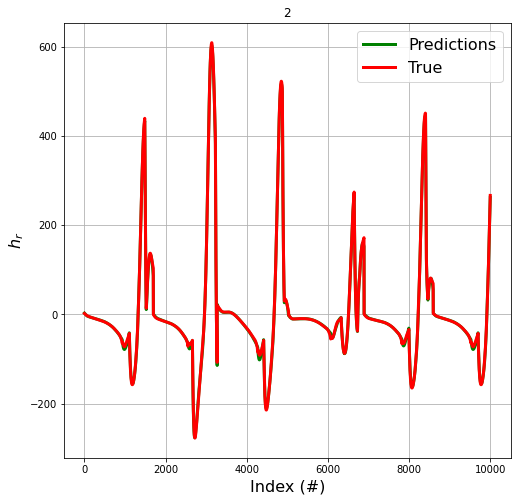

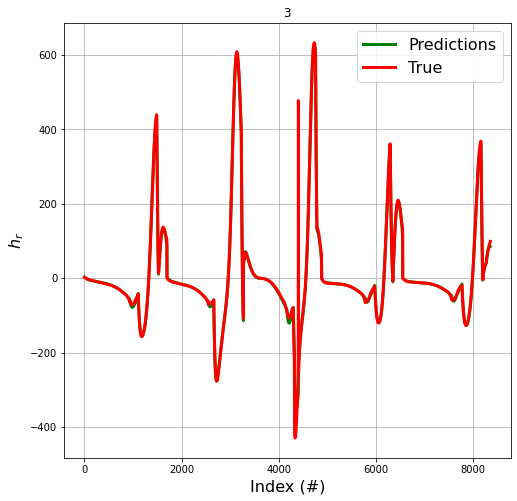

In [ ]:
## OLD CODE FOR SINGLE BATCH

In [ ]:
# Load Data

# Data will be read in from a .csv file containing data from all episodes concatenated, and stored as a numpy array
# Each line of data will consist of (x, theta, x_dot, theta_dot, dh_dx, dh_dtheta, dh_dxdot, dh_dthetadot, u, hdot_r)

# Read from .csv file
data = genfromtxt('../learning_data/batch_L.csv', delimiter=',')

# Split data
step_num_data = data[:,0]
stance_data = data[:,1]
model_input_data = data[:, 2:12]
control_data = data[:, 12:16]
h_r_long_data = data[:, 16]
h_r_short_data = data[:,17]


In [ ]:
# Configure Model



# Training Parameters
optimizer = 'adam'
loss = 'mean_absolute_error'
batch_size = 1
num_epochs = 10
validation_split = 0.1

# Drift Model
drift_model = Sequential() # Model structure
drift_model.add(Dense(d_hidden, input_shape=(d_drift_in,), activation='relu')) # Hidden layer
drift_model.add(Dense(d_out)) # Output layer
drift_inputs = Input((d_drift_in,)) # Define input to model
drift_residuals = drift_model(drift_inputs) # Define input to 

# Actuation Model
act_model = Sequential()
act_model.add(Dense(d_hidden, input_shape=(d_act_in,), activation='relu'))
act_model.add(Dense(d_out * m))
act_model.add(Reshape((d_out, m)))
act_inputs = Input((d_act_in,))
act_residuals = act_model(act_inputs)

us = Input((m,))

residuals = Add()([drift_residuals, Dot([2, 1])([act_residuals, us])])
model = Model([drift_inputs, act_inputs, us], residuals)
model.compile(optimizer, loss)


In [ ]:
# Shuffle Data

perm = permutation(len(h_r_long_data)) # permutation order

# Permute Data
step_num_data = data[:,0]
stance_data = data[:,1]
model_input_data_perm = model_input_data[perm]
control_data_perm = control_data[perm]
h_r_long_data_perm = h_r_long_data[perm]

In [ ]:
# Train Model

model.fit([model_input_data_perm, model_input_data_perm, control_data_perm], 
          h_r_long_data_perm, batch_size = batch_size, epochs = num_epochs, validation_split = validation_split)

In [ ]:
# Evaluate Model

drift_predictions = drift_model.predict(model_input_data)
act_predictions = act_model.predict(model_input_data)
h_r_predictions = array([dp + dot(ap, cd.transpose()) for dp, ap, cd, in zip(drift_predictions, act_predictions, control_data)])


In [ ]:
last = 0 
first_step = [0]
for i in range(len(step_num_data)):
    if last > step_num_data[i]: 
        first_step.append(i)
    last = step_num_data[i]



In [ ]:
names = ['4I24A2.csv','4I29A1.csv','Best.csv','I10A1.csv','I10A2.csv','I11A1.csv','I14A1.csv','I14A2.csv','I16A1.csv','I19A1.csv','I19A2.csv','I1A1.csv','I1A2.csv','I20A1.csv','I21A1.csv','I22A1.csv','I22A2.csv','I23A1.csv','I23A2.csv','I27A1.csv','I27A2.csv','I28A1.csv','I29A1.csv','I29A2.csv','I2A1.csv','I2A2.csv','I33A1.csv','I33A2.csv','I35A2.csv','I38A1.csv','I38A2.csv','I4A1.csv','I5A1.csv','I5A2.csv','I6A1.csv','I6A2.csv','I8A1.csv','I9A1.csv','StateBasedWalking.csv']
for x0 in first_step: 
    xend =  x0 +4500
    figure(figsize=(8, 8))
    cla()
    plot(h_r_predictions[x0:xend], 'g', linewidth=3, label='Predictions')
    plot(h_r_long_data[x0: xend], 'r', linewidth=3, label='True')
    grid()
    xlabel('Index (#)', fontsize=16)
    ylabel('$h_r$', fontsize=16)
    #plt.xlim((10500,11000))
    legend(fontsize = 16)
    title(names[first_step.index(x0)])
    show()
        

In [ ]:

figure(figsize=(8, 8))
cla()
plot(h_r_predictions[x0:xend], 'g', linewidth=3, label='Predictions')
plot(h_r_long_data[x0: xend], 'r', linewidth=3, label='True')
grid()
xlabel('Index (#)', fontsize=16)
ylabel('$h_r$', fontsize=16)
#plt.xlim((10500,11000))
legend(fontsize = 16)
show()

In [ ]:
# Extract Model Parameters & Save

# Layers are stored in *_model.layers, use get_weights() to pull out parameters indexed by layer
# Divide parameter sets by layers and model
drift_l1_params = drift_model.layers[0].get_weights()
drift_l2_params = drift_model.layers[1].get_weights()
act_l1_params = act_model.layers[0].get_weights()
act_l2_params = act_model.layers[1].get_weights()

# Extract drift weights and bias.
drift_w_1 = drift_l1_params[0].T
drift_b_1 = drift_l1_params[1].T
drift_w_2 = drift_l2_params[0].T
drift_b_2 = drift_l2_params[1].T

# Extract actuation weights and bias.
act_w_1 = act_l1_params[0].T
act_b_1 = act_l1_params[1].T
act_w_2 = act_l2_params[0].T
act_b_2 = act_l2_params[1].T

savetxt("../network_parameters/drift_w_1.csv", drift_w_1, delimiter=",")
savetxt("../network_parameters/drift_b_1.csv", drift_b_1, delimiter=",")
savetxt("../network_parameters/drift_w_2.csv", drift_w_2, delimiter=",")
savetxt("../network_parameters/drift_b_2.csv", drift_b_2, delimiter=",")
savetxt("../network_parameters/act_w_1.csv", act_w_1, delimiter=",")
savetxt("../network_parameters/act_b_1.csv", act_b_1, delimiter=",")
savetxt("../network_parameters/act_w_2.csv", act_w_2, delimiter=",")
savetxt("../network_parameters/act_b_2.csv", act_b_2, delimiter=",")
